# Carregando Pacotes

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import sklearn as sl #sl.__version__
from plotnine import *

import scorecardpy as sc

In [2]:
os.listdir()

['Calculo_RiscoRelativo.xlsx',
 'Calculo_RiscoRelativo_format_scorecard.csv',
 'Codigos_Python.ipynb',
 'df_tidy.pkl',
 'Feature_Selection_Test.ipynb',
 'funcoes_auxiliares_ds.py',
 'modelo_classificador_final.sav',
 'test_tidy.pkl',
 'Titanic-Kaggle-Python',
 'train_tidy.pkl',
 '__pycache__']

# Definindo funções

## Funções - Metadados

In [3]:
def tabela_metadados(tabela_de_entrada,sufixo_da_tabela_saída,lista_vars_drop):
    
    print('___________________________________________________________________')
    print("O shape da tabela de entrada é: ") 
    print(tabela_de_entrada.shape)

    # Nome das colunas
    metadata_table = pd.DataFrame(tabela_de_entrada.columns)
    metadata_table = metadata_table.rename(columns={0:'columns'})
    
    # Tipo do dado de cada coluna
    metadata_table['dtypes'] = tabela_de_entrada.dtypes.values

    # Número de valores únicos (Cardinalidade)
    metadata_table['nunique'] = tabela_de_entrada.nunique().values
    
    # Número de valores nulos e Porcentagem de valores nulos
    metadata_table['null_value_count'] = tabela_de_entrada.isnull().sum().values
    metadata_table['p_null_value_count'] = (tabela_de_entrada.isnull().sum()/tabela_de_entrada.shape[0]).values
    
    # Porcentagem de valores repetidos da moda em relação aos valores não nulos
    metadata_table['p_max_duplicated_value'] = np.NaN
    for j in range(0,tabela_de_entrada.shape[1]):
        lista = list(tabela_de_entrada.iloc[:,j]) # Transforma a coluna em uma lista
        moda = max(lista,key=lista.count) # Encontra a moda
        maximo_percentage = tabela_de_entrada[tabela_de_entrada.iloc[:,j]==moda].shape[0]/tabela_de_entrada.count()[j]
        metadata_table.loc[j,'p_max_duplicated_value'] = maximo_percentage
    
     # Número de valores únicos (Cardinalidade) (+ 1 se tiver valor nulo)
    metadata_table['nunique_with_null'] = tabela_de_entrada.nunique().values
    nunique_with_null_aux = metadata_table.loc[metadata_table['null_value_count'] > 0].nunique_with_null + 1
    metadata_table.loc[nunique_with_null_aux.index,'nunique_with_null'] = nunique_with_null_aux.values
    
    # Adiciona descrições de cada variável (Para facilitar na hora das legendas, labels e levels dos gráficos - útil na hora de apresentar pra cliente)
    # <em progresso>

    # Reorganiza a ordem das colunas
    metadata_table = metadata_table[['columns','dtypes','nunique','nunique_with_null','null_value_count','p_null_value_count','p_max_duplicated_value']]
    
    metadata_table['drop'] = metadata_table['columns'].isin(lista_vars_drop)

 

    # Salva a tabela na memória
    globals()['metadata_table_' + sufixo_da_tabela_saída] = metadata_table
    print('Tabela ' + 'metadata_table_' + sufixo_da_tabela_saída + ' criada!')
    return globals()['metadata_table_' + sufixo_da_tabela_saída]



## Funções - Análise Univariada

### Variável Qualitativa

In [4]:
##### Distribuição de Frequências (Variável Qualitativa)

def calcula_tab_frequencia(tabela_de_entrada,nome_variavel):
    
    globals()['table_count_prop' + nome_variavel] = pd.DataFrame(tabela_de_entrada[nome_variavel].value_counts(sort=False))
    globals()['table_count_prop' + nome_variavel][nome_variavel+'_P'] = round((globals()['table_count_prop' + nome_variavel][nome_variavel]/globals()['table_count_prop' + nome_variavel][nome_variavel].sum())*100,2)
    globals()['table_count_prop' + nome_variavel].reset_index(inplace=True)
    globals()['table_count_prop' + nome_variavel] = globals()['table_count_prop' + nome_variavel].sort_values(by='index',ascending=False)
    globals()['table_count_prop' + nome_variavel]['Acc'+nome_variavel] = globals()['table_count_prop' + nome_variavel][nome_variavel].cumsum()
    globals()['table_count_prop' + nome_variavel]['Acc'+nome_variavel+'_P'] = globals()['table_count_prop' + nome_variavel][nome_variavel+'_P'].cumsum()
    print('Tabela ' + 'table_count_prop' + nome_variavel + ' criada!')
    return globals()['table_count_prop' + nome_variavel]

def grafico_tab_frequencia(table_count_prop,nome_variavel,cor_grafico,nudge_x_e,nudge_x_d,size):

    globals()['gg_count_prop' + nome_variavel] = ggplot(aes(x='index',y=nome_variavel),data=table_count_prop) + theme_classic() + \
                                                        geom_col(fill=cor_grafico) + \
                                                        geom_text(aes(label=nome_variavel),                                   
                                                                va='bottom',nudge_x = nudge_x_e, 
                                                                size=size, format_string='{} ') + \
                                                        geom_text(aes(label=nome_variavel+'_P'),                                 
                                                                va='bottom',nudge_x = nudge_x_d,
                                                                size=size, format_string='({}%)')
    print('Gráfico ' + 'gg_count_prop' + nome_variavel + ' criado!')
    return globals()['gg_count_prop' + nome_variavel]


def grafico_tab_frequencia2(table_count_prop,nome_variavel,cor_grafico,size,angle):
    globals()['gg_count_prop' + nome_variavel] = ggplot(aes(x='index',y=nome_variavel),data=table_count_prop) + theme_classic() + \
                                                        geom_col(fill=cor_grafico) + theme(axis_text_x=element_text(angle=angle)) + \
                                                        geom_text(aes(label=nome_variavel+'_P'),                                 
                                                                va='bottom',size=size, format_string='{}%') 
    print('Gráfico ' + 'gg_count_prop' + nome_variavel + ' criado!')
    return globals()['gg_count_prop' + nome_variavel]

def grafico_tab_frequencia3(table_count_prop,nome_variavel,cor_grafico,size1=12,size2=12,angle=45):
    globals()['gg_count_prop' + nome_variavel] = ggplot(aes(x='index',y=nome_variavel),data=table_count_prop) + theme_classic() + \
                                                        geom_col(fill=cor_grafico) + theme(axis_text_x=element_text(angle=angle)) + \
                                                        geom_text(aes(label=nome_variavel),                                 
                                                                va='bottom',size=size1, format_string='{}') + \
                                                        geom_label(aes(label=nome_variavel+'_P'),                               
                                                                nudge_y=-2,va='top',size=size2, format_string='{}%',
                                                                alpha=0.8)# + geom_label(aes(label = nome_variavel+'_P'),va='top')                               
    print('Gráfico ' + 'gg_count_prop' + nome_variavel + ' criado!')
    return globals()['gg_count_prop' + nome_variavel]

### Variável Quantitativa

In [5]:
##### Distribuição de Frequências (Variável Quantitativa)

# Cálculo do número de categorias (Sturges)
# def calcula_num_categorias_sturges(n):
#     global k
#     k = int(round(1 + 3.322 * np.log10(n), 0))
#     return (n,k)

# Definindo os intervalos de um histograma
def binning_quantities(dados_entrada,nome_variavel,nome_variavel_resposta,method='Sturges'):
    #global dados_saida
    # dados_entrada # Dados para calculo dos intervalos
    #dados_entrada = df[df.Sample == 'train']['variavel']

    if method == 'Sturges':
        n = dados_entrada[~dados_entrada[nome_variavel].isnull()].shape[0]
        k = int(round(1 + 3.322 * np.log10(n), 0))
        interval = pd.cut(dados_entrada[nome_variavel], k, include_lowest=True,retbins=True)
        print('Método Sturges : n (desconsidera nulos) = ',n,'|> k (desconsidera nulos) = ',k)
    elif method == 'Percentiles':
        #percentiles = np.array(list(range(0,105,5)))/100 # 20 faixas
        percentiles = np.array(list(range(0,110,10)))/100 # 10 faixas
        interval = pd.qcut(dados_entrada[nome_variavel], percentiles, retbins=True)
        print('Método Percentiles:')

    # Inclui os valores np.-inf e np.inf nos intervalos
    interval = interval[1] # limites
    interval = interval[1:interval.shape[0]-1]
    globals()['limites_intervalos' + nome_variavel] = list([-np.Inf] + list(interval) + [np.Inf])
    globals()['limites_intervalos' + nome_variavel] = [round(i,2) for i in globals()['limites_intervalos' + nome_variavel]]
    bins = pd.IntervalIndex.from_breaks(globals()['limites_intervalos' + nome_variavel])
    #bins

    #-------------------------------------------------------------------------

    # dados_aplicacao_saida # Dados que serão utilizados para a aplicação dos intervalos calculados
    #dados_aplicacao_saida = df['variavel']

    # dados_saida # Dados alterados com a aplicação dos intervalos calculados
    dados_saida =  pd.cut(dados_entrada[nome_variavel], bins) # Faz a aplicação de acordo com os intervalos calculados

    # # Adicionando a categoria Missing aos intervalos
    dados_saida = dados_saida.cat.add_categories(['Missing'])

    # # Reorganizando os intervalos
    categorias = list(dados_saida.cat.categories.values)
    categorias_missing = [dados_saida.cat.categories.values[-1]]
    categorias_missing.extend(list(dados_saida.cat.categories.values[:-1]))

    dados_saida = dados_saida.cat.reorder_categories(categorias_missing)

    # # # Substitui os valores nulos por 'Missing'
    dados_saida = dados_saida.fillna('Missing')
    print(dados_saida)

    print('--------------------------------------------------------------------------------------------------')
    dados_saida = pd.DataFrame(dados_saida)
    dados_saida = pd.DataFrame(dados_saida[nome_variavel].values,dados_entrada[nome_variavel_resposta].values).reset_index().rename(columns={'index':nome_variavel_resposta,0:nome_variavel})
    print(dados_saida.dtypes)
    
    print('-------------------------------------------------')
    print('Tabela dados_saida' + nome_variavel + ' e lista limites_intervalos' + nome_variavel + ' criadas!')

    globals()['dados_saida' + nome_variavel] = dados_saida
    return globals()['dados_saida' + nome_variavel], globals()['limites_intervalos' + nome_variavel]

def apply_binning(dados_entrada,nome_variavel,breaks):
    bins = pd.IntervalIndex.from_breaks(breaks)
    #-------------------------------------------------------------------------

    # dados_aplicacao_saida # Dados que serão utilizados para a aplicação dos intervalos calculados
    #dados_aplicacao_saida = df['variavel']

    # dados_saida # Dados alterados com a aplicação dos intervalos calculados
    dados_saida =  pd.cut(dados_entrada[nome_variavel], bins) # Faz a aplicação de acordo com os intervalos calculados

    # # Adicionando a categoria Missing aos intervalos
    dados_saida = dados_saida.cat.add_categories(['Missing'])

    # # Reorganizando os intervalos
    categorias = list(dados_saida.cat.categories.values)
    categorias_missing = [dados_saida.cat.categories.values[-1]]
    categorias_missing.extend(list(dados_saida.cat.categories.values[:-1]))

    dados_saida = dados_saida.cat.reorder_categories(categorias_missing)

    # # # Substitui os valores nulos por 'Missing'
    dados_saida = dados_saida.fillna('Missing')
    print(dados_saida)

    print('--------------------------------------------------------------------------------------------------')
    dados_saida = pd.DataFrame(dados_saida)
    print(dados_saida.dtypes)
    
    print('-------------------------------------------------')
    print('Tabela dados_saida' + nome_variavel + ' criada!')
    
    print('-------------------------------------------------')
    print('Coluna',nome_variavel,'da tabela de entrada original modificada!')
    
    globals()['dados_saida' + nome_variavel] = dados_saida
    dados_entrada[[nome_variavel]] = dados_saida
    return globals()['dados_saida' + nome_variavel],dados_entrada[nome_variavel]


## Funções - Análise Bivariada

In [6]:
def calcula_tab_frequencia_bivariada(tabela_de_entrada,nome_variavel1,nome_variavel2):
   
    # tabela_de_entrada # df[df.Sample == 'train']
    # nome_variavel1 # 'Survived'
    # nome_variavel2 # 'Pclass'

    # Tabela de Frequência Bivariada
    globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2] = pd.DataFrame(tabela_de_entrada[[nome_variavel1, nome_variavel2]].value_counts(sort=False)).reset_index()
    globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2] = globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2].rename(columns={0:'Contagem'})

    # Acrescenta a soma total de cada nível da covariável
    globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2] = globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2].merge(globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2].groupby(nome_variavel2)['Contagem'].sum().reset_index().rename(columns={'Contagem':'Sum' + nome_variavel2}),on=nome_variavel2)
    
    # Acrescenta a soma acumulada total de cada nível da covariável
    cumsum_aux = globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2].groupby(nome_variavel2)['Contagem'].sum().reset_index()
    cumsum_aux['AccSum' + nome_variavel2] = cumsum_aux['Contagem'].cumsum()
    cumsum_aux['AccSum' + nome_variavel2 + '_P'] = round((cumsum_aux['Contagem']/cumsum_aux['Contagem'].sum())*100,2)
    globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2] = globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2].merge(cumsum_aux[[nome_variavel2,'AccSum' + nome_variavel2,'AccSum' + nome_variavel2 + '_P']],on=nome_variavel2)

    # Acrescenta a proporção da resposta em relação a cada nível da covariável 
    globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2][nome_variavel1 + '/' + 'Sum' + nome_variavel2] = round((globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2]['Contagem']/globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2]['Sum' + nome_variavel2]),4)
    globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2][nome_variavel1 + '/' + 'Sum' + nome_variavel2 + '_P'] = round(globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2][nome_variavel1 + '/' + 'Sum' + nome_variavel2]*100,1)
    
    print('Tabela table_count_prop' + nome_variavel1 + '_' + nome_variavel2 + ' criada!')
    return globals()['table_count_prop' + nome_variavel1 + '_' + nome_variavel2]

def grafico_tab_frequencia_bivariada1(table_count_prop,nome_variavel1,nome_variavel2,angle=0):
    globals()['gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '1'] = ggplot(aes(x=nome_variavel2,y='Contagem',fill=nome_variavel1),data=table_count_prop) + theme_classic() + \
                                                                                geom_col() + theme(axis_text_x=element_text(angle=angle)) + \
                                                                                geom_text(aes(y='Sum' + nome_variavel2,label='Sum' + nome_variavel2),
                                                                                    data=table_count_prop,
                                                                                    nudge_x=-0.2,va = 'bottom', format_string='{} /') + \
                                                                                geom_text(aes(y='Sum' + nome_variavel2,label='AccSum' + nome_variavel2 + '_P'),
                                                                                    data=table_count_prop,
                                                                                    nudge_x=0.2,va='bottom',format_string='({}%)')
    print('Gráfico ' + 'gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '1' + ' criado!')
    return globals()['gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '1']

def grafico_tab_frequencia_bivariada2(table_count_prop,nome_variavel1,nome_variavel2,size1=12,size2=12,angle=0):
    if size2 != 0:
        print('Para retirar as porcentagens, use size2 = 0!')
    elif size2 == 0:
        print('Para adicionar as porcentagens, use size2 > 0!')
    
    globals()['gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '2'] = ggplot(aes(x=nome_variavel2,y='Contagem',fill=nome_variavel1),data=table_count_prop) + theme_classic() + ylim(0,round(table_count_prop['Contagem'].max()*1.1,0)) + \
                                                                                geom_col(position="dodge") + theme(axis_text_x=element_text(angle=angle)) + \
                                                                                geom_text(aes(label='Contagem'),data=table_count_prop,
                                                                                size=size1, format_string='{}',
                                                                                position = position_dodge(0.9),va='bottom') + \
                                                                                geom_text(aes(y='Contagem',label=nome_variavel1 + '/' + 'Sum' + nome_variavel2 + '_P'),data=table_count_prop,
                                                                                size=size2, format_string='({}%) \n',
                                                                                position = position_dodge(0.9),va='bottom',color='black')
    print('Gráfico ' + 'gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '2' + ' criado!')
    return globals()['gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '2']

def grafico_tab_frequencia_bivariada3(table_count_prop,nome_variavel1,nome_variavel2,size1=12,size2=12,angle=0):
    if size2 != 0:
        print('Para retirar as contagens, use size2 = 0!')
    elif size2 == 0:
        print('Para adicionar as contagens, use size2 > 0!')
    
    globals()['gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '3'] = ggplot(aes(x=nome_variavel2,y='Contagem',fill=nome_variavel1),data=table_count_prop) + theme_classic() + \
                                                                                geom_col(position="fill",stat="identity") + theme(axis_text_x=element_text(angle=angle)) + \
                                                                                geom_text(aes(y=nome_variavel1 + '/' + 'Sum' + nome_variavel2,label=nome_variavel1 + '/' + 'Sum' + nome_variavel2 + '_P'),data=table_count_prop,
                                                                                size=size1, format_string='{}%',position = "stack",va='bottom') + \
                                                                                geom_text(aes(y=nome_variavel1 + '/' + 'Sum' + nome_variavel2,label='Contagem'),data=table_count_prop,
                                                                                size=size2, format_string='{}',position = "stack",va='top',color='black')
    print('Gráfico ' + 'gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '3' + ' criado!')
    return globals()['gg_count_prop' + nome_variavel1 + '_' + nome_variavel2 + '3']

# Importando os dados e juntando as tabelas

In [7]:
train = pd.read_csv('../train.csv',sep = ",")
test = pd.read_csv('../test.csv',sep = ",")
print(train.shape)
print(test.shape)
print(train.shape[0] + test.shape[0])

(891, 12)
(418, 11)
1309


In [8]:
train['Sample'] = 'train'

test['Survived'] = np.nan
test['Sample'] = 'test'
test = test[train.columns]

In [9]:
df = pd.concat([train,test])

# Pré-processamento para a tabela de Metadados

In [10]:
df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Sample          object
dtype: object

In [11]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test


Alteração do dtypes

In [12]:
df['Survived'] = df['Survived'].astype('category')
df['Pclass'] = pd.Series(pd.Categorical(df['Pclass'],categories=[1,2,3], ordered=True))
df['Sex'] = df['Sex'].astype('category')
df['Cabin'] = df['Cabin'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

# Tabela de Metadados (Foco na Análise Exploratória e Tratamento dos dados)

In [13]:
tabela_metadados(tabela_de_entrada=df[df.Sample == 'train'],
                 sufixo_da_tabela_saída='df_train',
                 lista_vars_drop=['PassengerId','Name','Ticket'])

___________________________________________________________________
O shape da tabela de entrada é: 
(891, 13)
Tabela metadata_table_df_train criada!


,columns,dtypes,nunique,nunique_with_null,null_value_count,p_null_value_count,p_max_duplicated_value,drop
0,PassengerId,int64,891,891,0,0.000000,0.001122,True
1,Survived,category,2,2,0,0.000000,0.616162,False
2,Pclass,category,3,3,0,0.000000,0.551066,False
3,Name,object,891,891,0,0.000000,0.001122,True
4,Sex,category,2,2,0,0.000000,0.647587,False
5,Age,float64,88,89,177,0.198653,0.042017,False
6,SibSp,int64,7,7,0,0.000000,0.682379,False
7,Parch,int64,7,7,0,0.000000,0.760943,False
8,Ticket,object,681,681,0,0.000000,0.007856,True
9,Fare,float64,248,248,0,0.000000,0.048260,False


In [14]:
tabela_metadados(tabela_de_entrada=df[df.Sample == 'test'],
                 sufixo_da_tabela_saída='df_test',
                 lista_vars_drop=['PassengerId','Name','Ticket'])

___________________________________________________________________
O shape da tabela de entrada é: 
(418, 13)
Tabela metadata_table_df_test criada!


<ipython-input-3-50043b968bee>:26: RuntimeWarning: invalid value encountered in longlong_scalars


,columns,dtypes,nunique,nunique_with_null,null_value_count,p_null_value_count,p_max_duplicated_value,drop
0,PassengerId,int64,418,418,0,0.000000,0.002392,True
1,Survived,category,0,1,418,1.000000,NaN,False
2,Pclass,category,3,3,0,0.000000,0.564593,False
3,Name,object,418,418,0,0.000000,0.002392,True
4,Sex,category,2,2,0,0.000000,0.636364,False
5,Age,float64,79,80,86,0.205742,0.051205,False
6,SibSp,int64,7,7,0,0.000000,0.677033,False
7,Parch,int64,8,8,0,0.000000,0.775120,False
8,Ticket,object,363,363,0,0.000000,0.011962,True
9,Fare,float64,169,170,1,0.002392,0.050360,False


In [15]:
tabela_metadados(tabela_de_entrada=df,
                 sufixo_da_tabela_saída='df',
                 lista_vars_drop=['PassengerId','Name','Ticket'])

___________________________________________________________________
O shape da tabela de entrada é: 
(1309, 13)
Tabela metadata_table_df criada!


,columns,dtypes,nunique,nunique_with_null,null_value_count,p_null_value_count,p_max_duplicated_value,drop
0,PassengerId,int64,1309,1309,0,0.000000,0.000764,True
1,Survived,category,2,3,418,0.319328,0.616162,False
2,Pclass,category,3,3,0,0.000000,0.555386,False
3,Name,object,1307,1307,0,0.000000,0.001528,True
4,Sex,category,2,2,0,0.000000,0.644003,False
5,Age,float64,98,99,263,0.200917,0.044933,False
6,SibSp,int64,7,7,0,0.000000,0.680672,False
7,Parch,int64,8,8,0,0.000000,0.765470,False
8,Ticket,object,929,929,0,0.000000,0.008403,True
9,Fare,float64,281,282,1,0.000764,0.045872,False


# Análise Descritiva e Exploratória

## Análise de Correlação

In [16]:
train.corr(method='pearson')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [17]:
train.corr(method='spearman')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.034091,0.041010,-0.061161,0.001235,-0.013975
Survived,-0.005007,1.000000,-0.339668,-0.052565,0.088879,0.138266,0.323736
Pclass,-0.034091,-0.339668,1.000000,-0.361666,-0.043019,-0.022801,-0.688032
Age,0.041010,-0.052565,-0.361666,1.000000,-0.182061,-0.254212,0.135051
SibSp,-0.061161,0.088879,-0.043019,-0.182061,1.000000,0.450014,0.447113
Parch,0.001235,0.138266,-0.022801,-0.254212,0.450014,1.000000,0.410074
Fare,-0.013975,0.323736,-0.688032,0.135051,0.447113,0.410074,1.000000


In [18]:
train.corr(method='spearman')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.034091,0.041010,-0.061161,0.001235,-0.013975
Survived,-0.005007,1.000000,-0.339668,-0.052565,0.088879,0.138266,0.323736
Pclass,-0.034091,-0.339668,1.000000,-0.361666,-0.043019,-0.022801,-0.688032
Age,0.041010,-0.052565,-0.361666,1.000000,-0.182061,-0.254212,0.135051
SibSp,-0.061161,0.088879,-0.043019,-0.182061,1.000000,0.450014,0.447113
Parch,0.001235,0.138266,-0.022801,-0.254212,0.450014,1.000000,0.410074
Fare,-0.013975,0.323736,-0.688032,0.135051,0.447113,0.410074,1.000000


In [19]:
test.corr(method='pearson')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,NaN,-0.026751,-0.034102,0.003818,0.043080,0.008211
Survived,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pclass,-0.026751,NaN,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.034102,NaN,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.003818,NaN,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.043080,NaN,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,0.008211,NaN,-0.577147,0.337932,0.171539,0.230046,1.000000


In [20]:
test.corr(method='spearman')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,NaN,-0.034246,-0.018897,-0.010179,0.050692,0.020174
Survived,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pclass,-0.034246,NaN,1.000000,-0.471535,-0.118701,-0.043345,-0.753744
Age,-0.018897,NaN,-0.471535,1.000000,-0.015126,-0.130408,0.315220
SibSp,-0.010179,NaN,-0.118701,-0.015126,1.000000,0.412449,0.441343
Parch,0.050692,NaN,-0.043345,-0.130408,0.412449,1.000000,0.378496
Fare,0.020174,NaN,-0.753744,0.315220,0.441343,0.378496,1.000000


## Análise Univariada

### Sample

In [21]:
calcula_tab_frequencia(tabela_de_entrada=df,
                       nome_variavel='Sample')

Tabela table_count_propSample criada!


,index,Sample,Sample_P,AccSample,AccSample_P
1,train,891,68.07,891,68.07
0,test,418,31.93,1309,100.00


Reordenando as categorias para plotar no gráfico

In [22]:
table_count_propSample_new_sort = table_count_propSample.copy()
#table_count_propCabin['index'][[1,5] + list(table_count_propCabin['index'].index[2:].values)]
table_count_propSample_new_sort['index'] = pd.Categorical(table_count_propSample_new_sort['index'])
table_count_propSample_new_sort['index'] = table_count_propSample_new_sort['index'].cat.reorder_categories(['train','test'])
table_count_propSample_new_sort['index']

1    train
0     test
Name: index, dtype: category
Categories (2, object): ['train', 'test']

Gráfico gg_count_propSample criado!


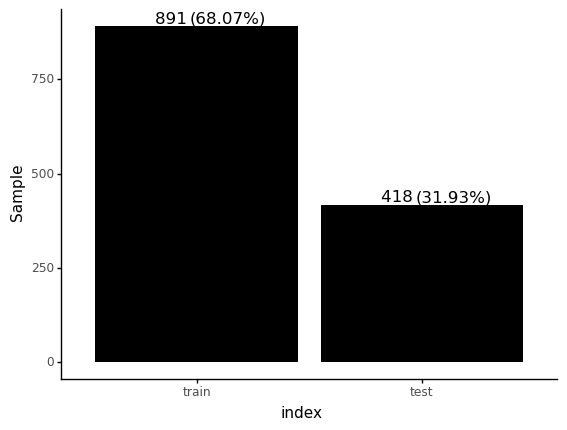

<ggplot: (125179882852)>

In [23]:
grafico_tab_frequencia(table_count_prop=table_count_propSample_new_sort,
                       nome_variavel='Sample',
                       cor_grafico='black',
                       nudge_x_e=-0.10,
                       nudge_x_d=0.14,
                       size=12)

### Survived (Resposta)

In [24]:
calcula_tab_frequencia(tabela_de_entrada=df[df.Sample == 'train'],
                       nome_variavel='Survived')

Tabela table_count_propSurvived criada!


,index,Survived,Survived_P,AccSurvived,AccSurvived_P
1,1.0,342,38.38,342,38.38
0,0.0,549,61.62,891,100.00


Gráfico gg_count_propSurvived criado!


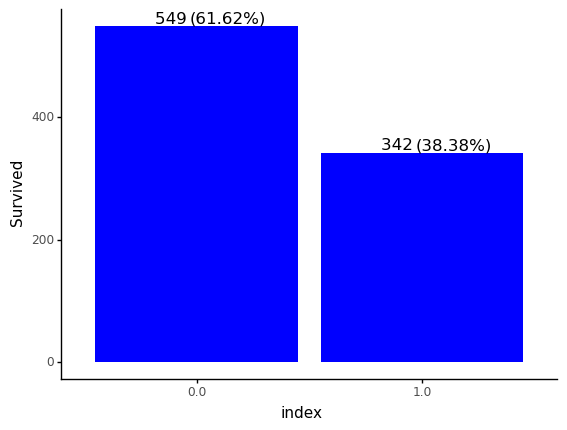

<ggplot: (125180392223)>

In [25]:
grafico_tab_frequencia(table_count_prop=table_count_propSurvived,
                       nome_variavel='Survived',
                       cor_grafico='blue',
                       nudge_x_e=-0.10,
                       nudge_x_d=0.14,
                       size=12)

## Análise Univariada e Bivariada

### Pclass

In [26]:
calcula_tab_frequencia(tabela_de_entrada=df[df.Sample == 'train'],
                       nome_variavel='Pclass')

Tabela table_count_propPclass criada!


,index,Pclass,Pclass_P,AccPclass,AccPclass_P
2,3,491,55.11,491,55.11
1,2,184,20.65,675,75.76
0,1,216,24.24,891,100.00


Gráfico gg_count_propPclass criado!


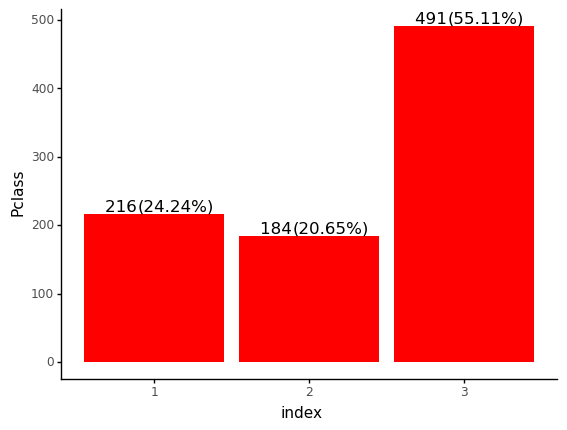

<ggplot: (125180422846)>

In [27]:
grafico_tab_frequencia(table_count_prop=table_count_propPclass,
                       nome_variavel='Pclass',
                       cor_grafico='red',
                       nudge_x_e=-0.2,
                       nudge_x_d=0.14,
                       size=12)

### Survived x Pclass

In [28]:
calcula_tab_frequencia_bivariada(df[df.Sample == 'train'],'Survived','Pclass')

Tabela table_count_propSurvived_Pclass criada!


,Survived,Pclass,Contagem,SumPclass,AccSumPclass,AccSumPclass_P,Survived/SumPclass,Survived/SumPclass_P
0,0.0,1,80,216,216,24.24,0.3704,37.0
1,1.0,1,136,216,216,24.24,0.6296,63.0
2,0.0,2,97,184,400,20.65,0.5272,52.7
3,1.0,2,87,184,400,20.65,0.4728,47.3
4,0.0,3,372,491,891,55.11,0.7576,75.8
5,1.0,3,119,491,891,55.11,0.2424,24.2


Para retirar as porcentagens, use size2 = 0!
Gráfico gg_count_propSurvived_Pclass2 criado!


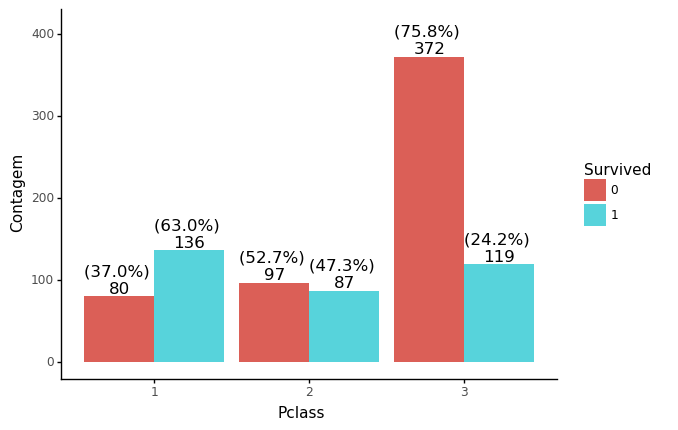

<ggplot: (125180457226)>

In [29]:
grafico_tab_frequencia_bivariada2(table_count_propSurvived_Pclass,'Survived','Pclass',angle=0,size1=12,size2=12)

Para adicionar as contagens, use size2 > 0!
Gráfico gg_count_propSurvived_Pclass3 criado!


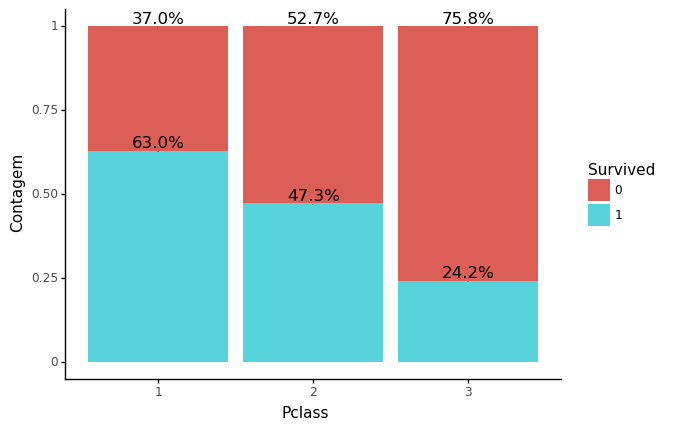

<ggplot: (125181555179)>

In [30]:
grafico_tab_frequencia_bivariada3(table_count_propSurvived_Pclass,'Survived','Pclass',size1=12,size2=0,angle=0)

## Sex

In [31]:
calcula_tab_frequencia(tabela_de_entrada=df[df.Sample == 'train'],
                       nome_variavel='Sex')

Tabela table_count_propSex criada!


,index,Sex,Sex_P,AccSex,AccSex_P
1,male,577,64.76,577,64.76
0,female,314,35.24,891,100.00


Gráfico gg_count_propSex criado!


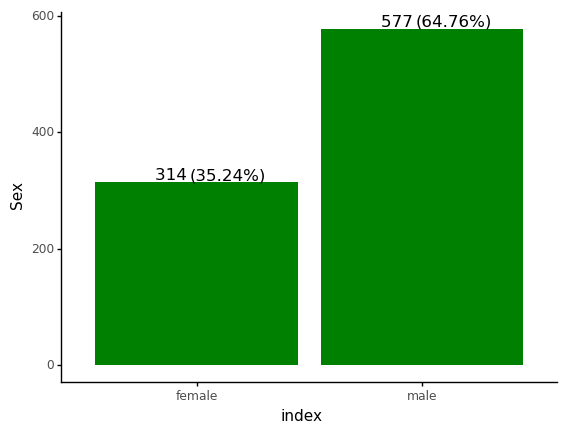

<ggplot: (125180457391)>

In [32]:
grafico_tab_frequencia(table_count_prop=table_count_propSex,
                       nome_variavel='Sex',
                       cor_grafico='green',
                       nudge_x_e=-0.1,
                       nudge_x_d=0.14,
                       size=12)

### Survived x Sex

In [33]:
calcula_tab_frequencia_bivariada(df[df.Sample == 'train'],'Survived','Sex')

Tabela table_count_propSurvived_Sex criada!


,Survived,Sex,Contagem,SumSex,AccSumSex,AccSumSex_P,Survived/SumSex,Survived/SumSex_P
0,0.0,female,81,314,314,35.24,0.2580,25.8
1,1.0,female,233,314,314,35.24,0.7420,74.2
2,0.0,male,468,577,891,64.76,0.8111,81.1
3,1.0,male,109,577,891,64.76,0.1889,18.9


Para retirar as porcentagens, use size2 = 0!
Gráfico gg_count_propSurvived_Sex2 criado!


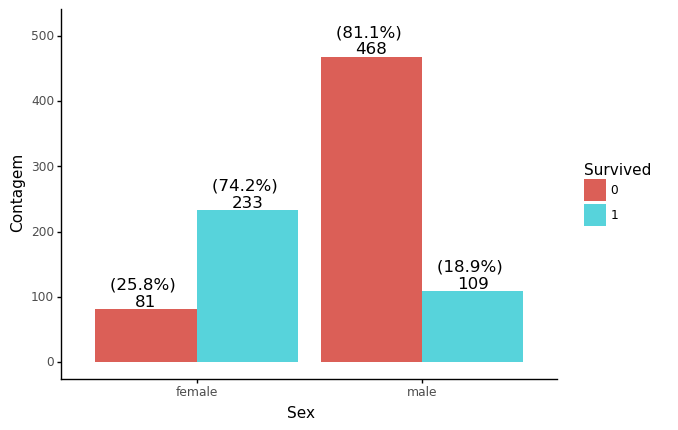

<ggplot: (125181604235)>

In [34]:
grafico_tab_frequencia_bivariada2(table_count_propSurvived_Sex,'Survived','Sex',angle=0,size1=12,size2=12)

Para adicionar as contagens, use size2 > 0!
Gráfico gg_count_propSurvived_Sex3 criado!


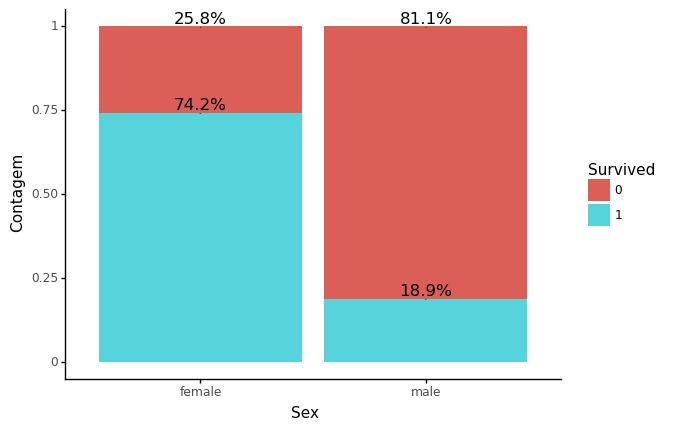

<ggplot: (125181594320)>

In [35]:
grafico_tab_frequencia_bivariada3(table_count_propSurvived_Sex,'Survived','Sex',size1=12,size2=0,angle=0)

## Age

### Binning para visualização **(Método Sturges)**

### Cálculo do número de categorias (**Sturges**)

In [36]:
binning_quantities(dados_entrada=df[df.Sample == 'train'],
                   nome_variavel='Age',
                   nome_variavel_resposta='Survived',
                   method='Sturges')

Método Sturges : n (desconsidera nulos) =  714 |> k (desconsidera nulos) =  10
0      (16.34, 24.29]
1      (32.25, 40.21]
2      (24.29, 32.25]
3      (32.25, 40.21]
4      (32.25, 40.21]
            ...      
886    (24.29, 32.25]
887    (16.34, 24.29]
888           Missing
889    (24.29, 32.25]
890    (24.29, 32.25]
Name: Age, Length: 891, dtype: category
Categories (11, object): ['Missing' < (-inf, 8.38] < (8.38, 16.34] < (16.34, 24.29] ... (48.17, 56.13] < (56.13, 64.08] < (64.08, 72.04] < (72.04, inf]]
--------------------------------------------------------------------------------------------------
Survived    category
Age         category
dtype: object
-------------------------------------------------
Tabela dados_saidaAge e lista limites_intervalosAge criadas!


(    Survived             Age
 0        0.0  (16.34, 24.29]
 1        1.0  (32.25, 40.21]
 2        1.0  (24.29, 32.25]
 3        1.0  (32.25, 40.21]
 4        0.0  (32.25, 40.21]
 ..       ...             ...
 886      0.0  (24.29, 32.25]
 887      1.0  (16.34, 24.29]
 888      0.0         Missing
 889      1.0  (24.29, 32.25]
 890      0.0  (24.29, 32.25]
 
 [891 rows x 2 columns],
 [-inf, 8.38, 16.34, 24.29, 32.25, 40.21, 48.17, 56.13, 64.08, 72.04, inf])

In [37]:
calcula_tab_frequencia(tabela_de_entrada=dados_saidaAge,
                       nome_variavel='Age')

Tabela table_count_propAge criada!


,index,Age,Age_P,AccAge,AccAge_P
10,"(72.04, inf]",2,0.22,2,0.22
9,"(64.08, 72.04]",9,1.01,11,1.23
8,"(56.13, 64.08]",24,2.69,35,3.92
7,"(48.17, 56.13]",45,5.05,80,8.97
6,"(40.21, 48.17]",70,7.86,150,16.83
5,"(32.25, 40.21]",118,13.24,268,30.07
4,"(24.29, 32.25]",169,18.97,437,49.04
3,"(16.34, 24.29]",177,19.87,614,68.91
2,"(8.38, 16.34]",46,5.16,660,74.07
1,"(-inf, 8.38]",54,6.06,714,80.13


Gráfico gg_count_propAge criado!


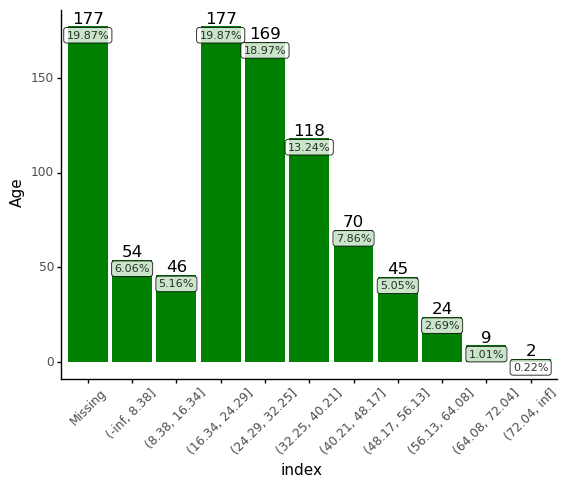

<ggplot: (125179878916)>

In [38]:
grafico_tab_frequencia3(table_count_prop=table_count_propAge,
                       nome_variavel='Age',
                       cor_grafico='green',
                       size1=12,
                       size2=8,
                       angle=45)

### Análise Bivariada

In [39]:
df[df.Sample == 'train'].groupby(['Survived'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0.0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1.0,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


C:\Users\joaom\anaconda3\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 177 rows containing non-finite values.


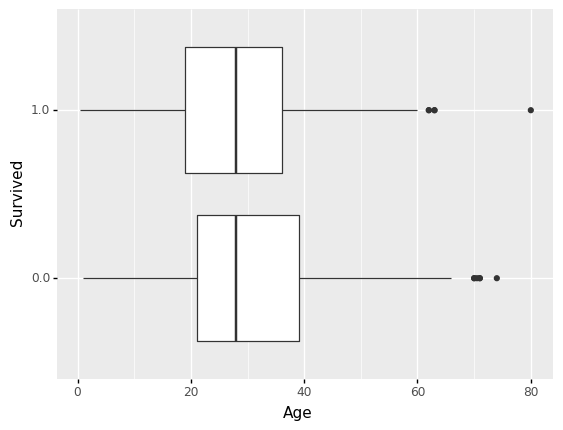

<ggplot: (125181877321)>

In [40]:
ggplot(aes(x='Survived',y='Age'),data=df[df.Sample == 'train']) + geom_boxplot() + coord_flip()

In [41]:
calcula_tab_frequencia_bivariada(dados_saidaAge,'Survived','Age')

Tabela table_count_propSurvived_Age criada!


,Survived,Age,Contagem,SumAge,AccSumAge,AccSumAge_P,Survived/SumAge,Survived/SumAge_P
0,0.0,Missing,125,177,177,19.87,0.7062,70.6
1,1.0,Missing,52,177,177,19.87,0.2938,29.4
2,0.0,"(-inf, 8.38]",18,54,231,6.06,0.3333,33.3
3,1.0,"(-inf, 8.38]",36,54,231,6.06,0.6667,66.7
4,0.0,"(8.38, 16.34]",27,46,277,5.16,0.5870,58.7
5,1.0,"(8.38, 16.34]",19,46,277,5.16,0.4130,41.3
6,0.0,"(16.34, 24.29]",114,177,454,19.87,0.6441,64.4
7,1.0,"(16.34, 24.29]",63,177,454,19.87,0.3559,35.6
8,0.0,"(24.29, 32.25]",104,169,623,18.97,0.6154,61.5
9,1.0,"(24.29, 32.25]",65,169,623,18.97,0.3846,38.5


Para adicionar as porcentagens, use size2 > 0!
Gráfico gg_count_propSurvived_Age2 criado!


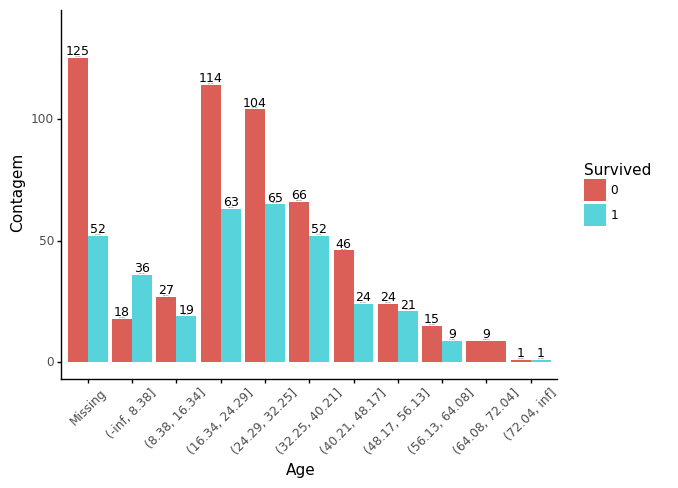

<ggplot: (125181926527)>

In [42]:
grafico_tab_frequencia_bivariada2(table_count_propSurvived_Age,'Survived','Age',size1=9,size2=0,angle=45)

Para adicionar as contagens, use size2 > 0!
Gráfico gg_count_propSurvived_Age3 criado!


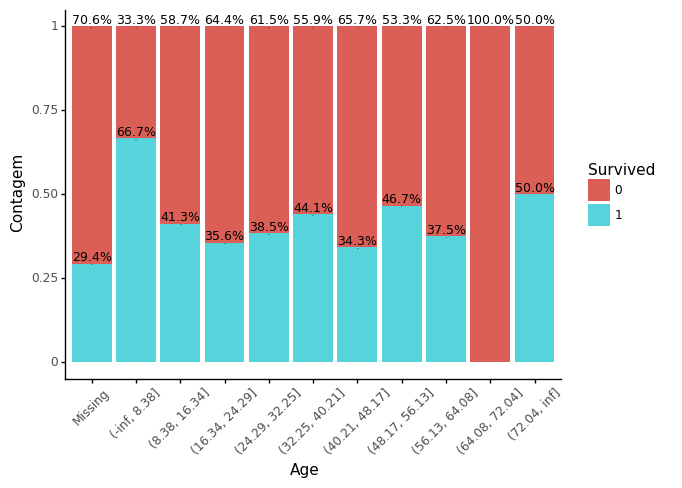

<ggplot: (125182143642)>

In [43]:
grafico_tab_frequencia_bivariada3(table_count_propSurvived_Age,'Survived','Age',size1=9,size2=0,angle=45)

#### Formata a variável resposta

In [44]:
df_for_woe = df.copy()
df_for_woe['Survived_BadGod'] = df_for_woe['Survived'].replace({0: 'bad', 1: 'good'})

### Binning 'Automático' **(Método Optimal Binning)**

In [45]:
# woe binning ------
bins = sc.woebin(df_for_woe[df_for_woe.Sample == 'train'],
                x='Age',
                y='Survived_BadGod',
                method='tree',# "tree" and "chimerge" for optimal binning (numerical e categorical), # width' and 'freq' for equal binning that support numerical variables only.
                stop_limit=0.05)
bins['Age']['woe_period1'] = bins['Age']['woe'].shift(periods=1)
bins['Age']['woe_diff'] = bins['Age']['woe_period1'] - bins['Age']['woe']
bins['Age']['P_j/good'] = bins['Age']['good']/bins['Age']['good'].sum()
bins['Age']['P_j/bad'] = bins['Age']['bad']/bins['Age']['bad'].sum()
bins['Age']['RR'] = bins['Age']['P_j/good']/bins['Age']['P_j/bad']
bins['Age']['f*'] = np.log(bins['Age']['RR'])
bins['Age']['V(f*)'] = ((1-bins['Age']['P_j/good'])/(bins['Age']['good'].sum()*bins['Age']['P_j/good'])) + ((1-bins['Age']['P_j/bad'])/(bins['Age']['bad'].sum()*bins['Age']['P_j/bad']))
bins['Age']['RR_IC_low'] = np.exp(bins['Age']['f*'] - stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Age']['V(f*)']))
bins['Age']['RR_IC_Hight'] = np.exp(bins['Age']['f*'] + stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Age']['V(f*)']))
bins['Age']

[INFO] creating woe binning ...


C:\Users\joaom\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:113: UserWarning: The positive value in "Survived_BadGod" was replaced by 1 and negative value by 0.


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,...,is_special_values,woe_period1,woe_diff,P_j/good,P_j/bad,RR,f*,V(f*),RR_IC_low,RR_IC_Hight
0,Age,missing,177,0.198653,52,125,0.706215,0.403782,0.030542,0.146078,...,True,NaN,NaN,0.152047,0.227687,0.667789,-0.403782,0.022485,0.497738,0.895938
1,Age,"[-inf,8.0)",50,0.056117,34,16,0.320000,-1.227060,0.086227,0.146078,...,False,0.403782,1.630842,0.099415,0.029144,3.411184,1.227060,0.087166,1.912480,6.084339
2,Age,"[8.0,18.0)",63,0.070707,27,36,0.571429,-0.185606,0.002482,0.146078,...,False,-1.227060,-1.041454,0.078947,0.065574,1.203947,0.185606,0.060069,0.744708,1.946386
3,Age,"[18.0,20.0)",51,0.057239,18,33,0.647059,0.132848,0.000993,0.146078,...,False,-0.185606,-0.318454,0.052632,0.060109,0.875598,-0.132848,0.081113,0.501048,1.530136
4,Age,"[20.0,24.0)",83,0.093154,24,59,0.710843,0.426196,0.015894,0.146078,...,False,0.132848,-0.293348,0.070175,0.107468,0.652988,-0.426196,0.053870,0.414326,1.029128
5,Age,"[24.0,54.0)",417,0.468013,171,246,0.589928,-0.109620,0.005691,0.146078,...,False,0.426196,0.535816,0.500000,0.448087,1.115854,0.109620,0.005168,0.969211,1.284684
6,Age,"[54.0,inf)",50,0.056117,16,34,0.680000,0.280484,0.004249,0.146078,...,False,-0.109620,-0.390104,0.046784,0.061931,0.755418,-0.280484,0.087166,0.423525,1.347397


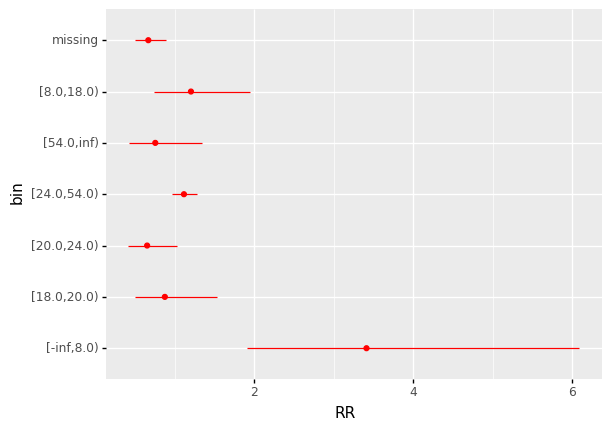

<ggplot: (125182131574)>

In [46]:
ggplot(aes(x='RR',y='bin'),data=bins['Age']) + geom_point(colour='red') + \
    geom_segment(aes(x = 'RR_IC_low', y = 'bin', xend = 'RR_IC_Hight', yend = 'bin'),colour='red')

{'Age': <Figure size 432x288 with 2 Axes>}

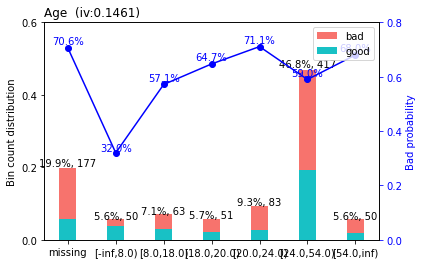

In [47]:
sc.woebin_plot(bins)

### Binning 'Manual' **(Método Percentiles) - Antes da fusão de classes**

In [48]:
binning_quantities(dados_entrada=df[df.Sample == 'train'],
                   nome_variavel='Age',
                   nome_variavel_resposta='Survived',
                   method='Percentiles')

Método Percentiles:
0      (19.0, 22.0]
1      (36.0, 41.0]
2      (25.0, 28.0]
3      (31.8, 36.0]
4      (31.8, 36.0]
           ...     
886    (25.0, 28.0]
887    (14.0, 19.0]
888         Missing
889    (25.0, 28.0]
890    (31.8, 36.0]
Name: Age, Length: 891, dtype: category
Categories (11, object): ['Missing' < (-inf, 14.0] < (14.0, 19.0] < (19.0, 22.0] ... (31.8, 36.0] < (36.0, 41.0] < (41.0, 50.0] < (50.0, inf]]
--------------------------------------------------------------------------------------------------
Survived    category
Age         category
dtype: object
-------------------------------------------------
Tabela dados_saidaAge e lista limites_intervalosAge criadas!


(    Survived           Age
 0        0.0  (19.0, 22.0]
 1        1.0  (36.0, 41.0]
 2        1.0  (25.0, 28.0]
 3        1.0  (31.8, 36.0]
 4        0.0  (31.8, 36.0]
 ..       ...           ...
 886      0.0  (25.0, 28.0]
 887      1.0  (14.0, 19.0]
 888      0.0       Missing
 889      1.0  (25.0, 28.0]
 890      0.0  (31.8, 36.0]
 
 [891 rows x 2 columns],
 [-inf, 14.0, 19.0, 22.0, 25.0, 28.0, 31.8, 36.0, 41.0, 50.0, inf])

In [49]:
calcula_tab_frequencia(tabela_de_entrada=dados_saidaAge,
                       nome_variavel='Age')

Tabela table_count_propAge criada!


,index,Age,Age_P,AccAge,AccAge_P
10,"(50.0, inf]",64,7.18,64,7.18
9,"(41.0, 50.0]",78,8.75,142,15.93
8,"(36.0, 41.0]",53,5.95,195,21.88
7,"(31.8, 36.0]",91,10.21,286,32.09
6,"(28.0, 31.8]",66,7.41,352,39.50
5,"(25.0, 28.0]",61,6.85,413,46.35
4,"(22.0, 25.0]",70,7.86,483,54.21
3,"(19.0, 22.0]",67,7.52,550,61.73
2,"(14.0, 19.0]",87,9.76,637,71.49
1,"(-inf, 14.0]",77,8.64,714,80.13


In [50]:
breaks_list = {
    'Age': limites_intervalosAge,
}
# woe binning ------
bins = sc.woebin(df_for_woe[df_for_woe.Sample == 'train'],
                breaks_list=breaks_list,
                #special_values=,
                x='Age',
                y='Survived_BadGod')
                
bins['Age']['woe_period1'] = bins['Age']['woe'].shift(periods=1)
bins['Age']['woe_diff'] = bins['Age']['woe_period1'] - bins['Age']['woe']
bins['Age']['P_j/good'] = bins['Age']['good']/bins['Age']['good'].sum()
bins['Age']['P_j/bad'] = bins['Age']['bad']/bins['Age']['bad'].sum()
bins['Age']['RR'] = bins['Age']['P_j/good']/bins['Age']['P_j/bad']
bins['Age']['f*'] = np.log(bins['Age']['RR'])
bins['Age']['V(f*)'] = ((1-bins['Age']['P_j/good'])/(bins['Age']['good'].sum()*bins['Age']['P_j/good'])) + ((1-bins['Age']['P_j/bad'])/(bins['Age']['bad'].sum()*bins['Age']['P_j/bad']))
bins['Age']['RR_IC_low'] = np.exp(bins['Age']['f*'] - stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Age']['V(f*)']))
bins['Age']['RR_IC_Hight'] = np.exp(bins['Age']['f*'] + stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Age']['V(f*)']))

bins['Age']

[INFO] creating woe binning ...


C:\Users\joaom\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:113: UserWarning: The positive value in "Survived_BadGod" was replaced by 1 and negative value by 0.


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,...,is_special_values,woe_period1,woe_diff,P_j/good,P_j/bad,RR,f*,V(f*),RR_IC_low,RR_IC_Hight
0,Age,missing,177,0.198653,52,125,0.706215,0.403782,0.030542,0.127798,...,True,NaN,NaN,0.152047,0.227687,0.667789,-0.403782,0.022485,0.497738,0.895938
1,Age,"[-inf,14.0)",71,0.079686,42,29,0.408451,-0.843661,0.059043,0.127798,...,False,0.403782,1.247444,0.122807,0.052823,2.324864,0.843661,0.053547,1.477161,3.659040
2,Age,"[14.0,19.0)",68,0.076319,28,40,0.588235,-0.116613,0.001051,0.127798,...,False,-0.843661,-0.727049,0.081871,0.072860,1.123684,0.116613,0.055969,0.706756,1.786567
3,Age,"[19.0,22.0)",65,0.072952,17,48,0.738462,0.564700,0.021303,0.127798,...,False,-0.116613,-0.681313,0.049708,0.087432,0.568531,-0.564700,0.074911,0.332491,0.972137
4,Age,"[22.0,25.0)",74,0.083053,31,43,0.581081,-0.146075,0.001800,0.127798,...,False,0.564700,0.710775,0.090643,0.078324,1.157283,0.146075,0.050768,0.744129,1.799828
5,Age,"[25.0,28.0)",59,0.066218,23,36,0.610169,-0.025263,0.000042,0.127798,...,False,-0.146075,-0.120812,0.067251,0.065574,1.025585,0.025263,0.066511,0.618657,1.700174
6,Age,"[28.0,31.8)",91,0.102132,33,58,0.637363,0.090648,0.000830,0.127798,...,False,-0.025263,-0.115911,0.096491,0.105647,0.913339,-0.090648,0.042799,0.608887,1.370023
7,Age,"[31.8,36.0)",69,0.077441,33,36,0.521739,-0.386276,0.011943,0.127798,...,False,0.090648,0.476924,0.096491,0.065574,1.471491,0.386276,0.053335,0.935788,2.313865
8,Age,"[36.0,41.0)",69,0.077441,28,41,0.594203,-0.091920,0.000661,0.127798,...,False,-0.386276,-0.294356,0.081871,0.074681,1.096277,0.091920,0.055359,0.691266,1.738583
9,Age,"[41.0,50.0)",74,0.083053,28,46,0.621622,0.023149,0.000044,0.127798,...,False,-0.091920,-0.115069,0.081871,0.083789,0.977117,-0.023149,0.052708,0.623054,1.532382


{'Age': <Figure size 432x288 with 2 Axes>}

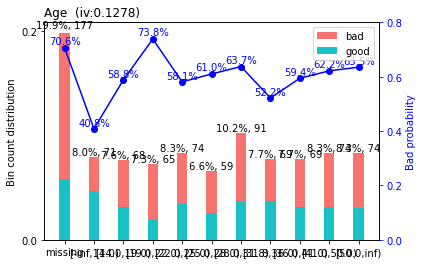

In [51]:
sc.woebin_plot(bins)

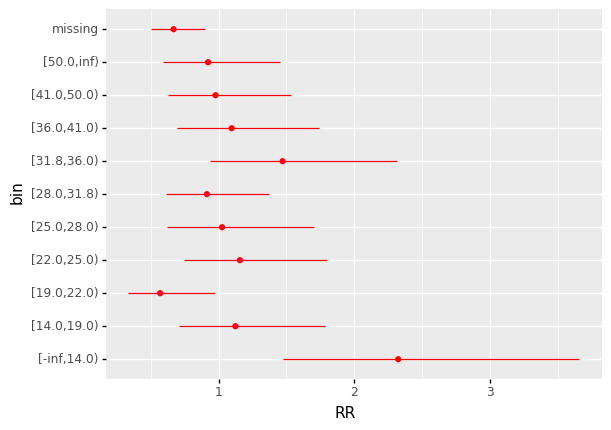

<ggplot: (125182452465)>

In [52]:
ggplot(aes(x='RR',y='bin'),data=bins['Age']) + geom_point(color='red') + \
    geom_segment(aes(x = 'RR_IC_low', y = 'bin', xend = 'RR_IC_Hight', yend = 'bin'),color='red')

### Binning 'Manual' **(Método Percentiles) - Depois da fusão de classes**

In [53]:
breaks_list = {
    'Age': [-np.inf,19.0,np.inf],
}
# woe binning ------
bins = sc.woebin(df_for_woe[df_for_woe.Sample == 'train'],
                breaks_list=breaks_list,
                #special_values=,
                x='Age',
                y='Survived_BadGod')
bins['Age']['woe_period1'] = bins['Age']['woe'].shift(periods=1)
bins['Age']['woe_diff'] = bins['Age']['woe_period1'] - bins['Age']['woe']
bins['Age']['P_j/good'] = bins['Age']['good']/bins['Age']['good'].sum()
bins['Age']['P_j/bad'] = bins['Age']['bad']/bins['Age']['bad'].sum()
bins['Age']['RR'] = bins['Age']['P_j/good']/bins['Age']['P_j/bad']
bins['Age']['f*'] = np.log(bins['Age']['RR'])
bins['Age']['V(f*)'] = ((1-bins['Age']['P_j/good'])/(bins['Age']['good'].sum()*bins['Age']['P_j/good'])) + ((1-bins['Age']['P_j/bad'])/(bins['Age']['bad'].sum()*bins['Age']['P_j/bad']))
bins['Age']['RR_IC_low'] = np.exp(bins['Age']['f*'] - stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Age']['V(f*)']))
bins['Age']['RR_IC_Hight'] = np.exp(bins['Age']['f*'] + stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Age']['V(f*)']))
bins['Age']

[INFO] creating woe binning ...


C:\Users\joaom\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:113: UserWarning: The positive value in "Survived_BadGod" was replaced by 1 and negative value by 0.


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,...,is_special_values,woe_period1,woe_diff,P_j/good,P_j/bad,RR,f*,V(f*),RR_IC_low,RR_IC_Hight
0,Age,missing,177,0.198653,52,125,0.706215,0.403782,0.030542,0.069084,...,True,NaN,NaN,0.152047,0.227687,0.667789,-0.403782,0.022485,0.497738,0.895938
1,Age,"[-inf,19.0)",139,0.156004,70,69,0.496403,-0.487676,0.038524,0.069084,...,False,0.403782,0.891459,0.204678,0.125683,1.628528,0.487676,0.024033,1.201813,2.206751
2,Age,"[19.0,inf)",575,0.645342,220,355,0.617391,0.005203,0.000017,0.069084,...,False,-0.487676,-0.492879,0.643275,0.646630,0.994811,-0.005203,0.002617,0.899906,1.099725


{'Age': <Figure size 432x288 with 2 Axes>}

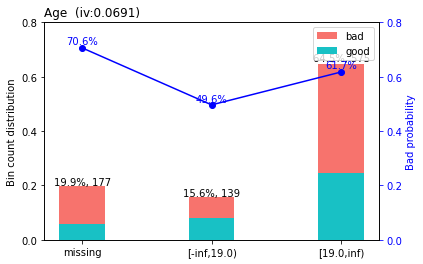

In [54]:
sc.woebin_plot(bins)

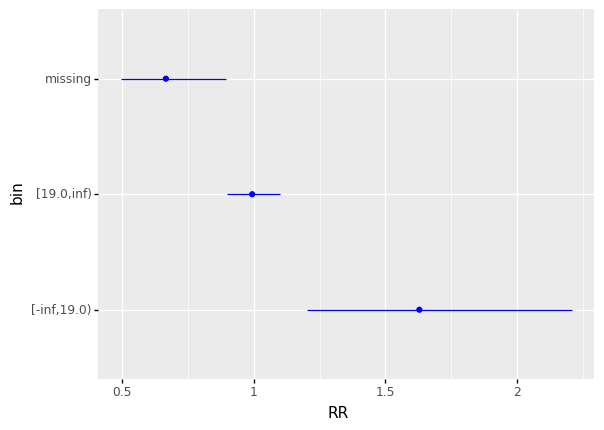

<ggplot: (125179885415)>

In [55]:
ggplot(aes(x='RR',y='bin'),data=bins['Age']) + geom_point(colour='blue') + \
    geom_segment(aes(x = 'RR_IC_low', y = 'bin', xend = 'RR_IC_Hight', yend = 'bin'),colour='blue')

**Dicas para discretização via WOE:**
1) Todas as categorias calculadas têm pelo menos 5% das observações.
2) Todas as categorias calculadas têm valores diferentes de zero para o número de casos bons e ruins.
3) Os Woe's são distintos para cada categoria calculada. As categorias calculadas que tinham Woe's semelhantes foram agrupadas.
4) Valores ausentes estão em categorias separadas.
5) Os Woe's são monotônicos, isto é, estão crescendo ou diminuindo com os agrupamentos. (Recomendação do uso dessa dica é mais fraca do que para as outras dicas).

O método **Binning 'Automático' (Método Optimal Binning)** ganha do método **Binning 'Manual' (Método Percentiles) - Antes da fusão de classes** e **Binning 'Manual' (Método Percentiles) - Depois da fusão de classes** no quesito valor da informação (0.146078 > 0.127798 > 0.069084), porém somente o método **Binning 'Manual' (Método Percentiles) - Depois da fusão de classes** obedece o quesito de monotonicidade (uma das dicas na discretização via WOE). Por conta da facilidade de interpretação da relação entre Age e Survived, optou-se por considerar a discretização via **Binning 'Manual' (Método Percentiles) - Depois da fusão de classes**.

### Aplicando as modificações nos dados

In [56]:
breaks = bins['Age']['breaks'][1:].values.astype(np.float64)
breaks = np.append(-np.inf,breaks)

apply_binning(df_for_woe,'Age',breaks)

0      (19.0, inf]
1      (19.0, inf]
2      (19.0, inf]
3      (19.0, inf]
4      (19.0, inf]
          ...     
413        Missing
414    (19.0, inf]
415    (19.0, inf]
416        Missing
417        Missing
Name: Age, Length: 1309, dtype: category
Categories (3, object): ['Missing' < (-inf, 19.0] < (19.0, inf]]
--------------------------------------------------------------------------------------------------
Age    category
dtype: object
-------------------------------------------------
Tabela dados_saidaAge criada!
-------------------------------------------------
Coluna Age da tabela de entrada original modificada!


(             Age
 0    (19.0, inf]
 1    (19.0, inf]
 2    (19.0, inf]
 3    (19.0, inf]
 4    (19.0, inf]
 ..           ...
 413      Missing
 414  (19.0, inf]
 415  (19.0, inf]
 416      Missing
 417      Missing
 
 [1309 rows x 1 columns],
 0      (19.0, inf]
 1      (19.0, inf]
 2      (19.0, inf]
 3      (19.0, inf]
 4      (19.0, inf]
           ...     
 413        Missing
 414    (19.0, inf]
 415    (19.0, inf]
 416        Missing
 417        Missing
 Name: Age, Length: 1309, dtype: category
 Categories (3, object): ['Missing' < (-inf, 19.0] < (19.0, inf]])

In [57]:
df_for_woe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample,Survived_BadGod
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(19.0, inf]",1,0,A/5 21171,7.2500,NaN,S,train,bad
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(19.0, inf]",1,0,PC 17599,71.2833,C85,C,train,good
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(19.0, inf]",0,0,STON/O2. 3101282,7.9250,NaN,S,train,good
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(19.0, inf]",1,0,113803,53.1000,C123,S,train,good
4,5,0.0,3,"Allen, Mr. William Henry",male,"(19.0, inf]",0,0,373450,8.0500,NaN,S,train,bad


In [58]:
calcula_tab_frequencia(tabela_de_entrada=dados_saidaAge,
                       nome_variavel='Age')

Tabela table_count_propAge criada!


,index,Age,Age_P,AccAge,AccAge_P
2,"(19.0, inf]",821,62.72,821,62.72
1,"(-inf, 19.0]",225,17.19,1046,79.91
0,Missing,263,20.09,1309,100.00


Gráfico gg_count_propAge criado!


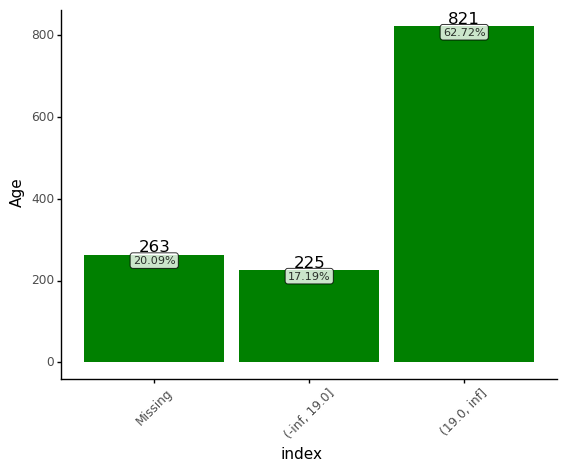

<ggplot: (125181555074)>

In [59]:
grafico_tab_frequencia3(table_count_prop=table_count_propAge,
                       nome_variavel='Age',
                       cor_grafico='green',
                       size1=12,
                       size2=8,
                       angle=45)

In [60]:
calcula_tab_frequencia_bivariada(df_for_woe[df_for_woe.Sample == 'train'],'Survived','Age')

Tabela table_count_propSurvived_Age criada!


,Survived,Age,Contagem,SumAge,AccSumAge,AccSumAge_P,Survived/SumAge,Survived/SumAge_P
0,0.0,Missing,125,177,177,19.87,0.7062,70.6
1,1.0,Missing,52,177,177,19.87,0.2938,29.4
2,0.0,"(-inf, 19.0]",85,164,341,18.41,0.5183,51.8
3,1.0,"(-inf, 19.0]",79,164,341,18.41,0.4817,48.2
4,0.0,"(19.0, inf]",339,550,891,61.73,0.6164,61.6
5,1.0,"(19.0, inf]",211,550,891,61.73,0.3836,38.4


Para retirar as porcentagens, use size2 = 0!
Gráfico gg_count_propSurvived_Age2 criado!


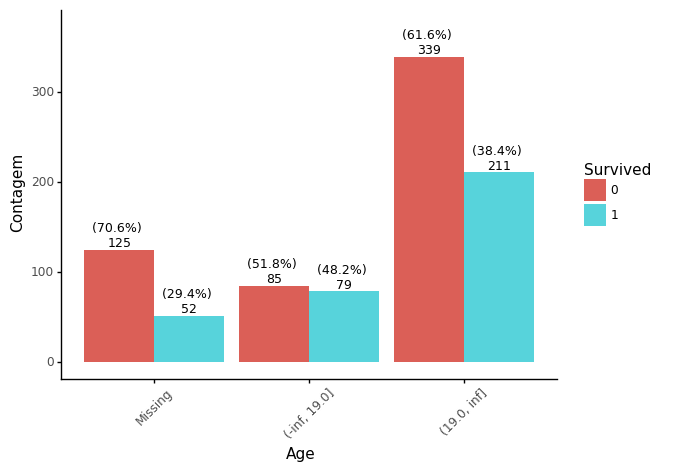

<ggplot: (125180394367)>

In [61]:
grafico_tab_frequencia_bivariada2(table_count_propSurvived_Age,'Survived','Age',size1=9,size2=9,angle=45)

Para adicionar as contagens, use size2 > 0!
Gráfico gg_count_propSurvived_Age3 criado!


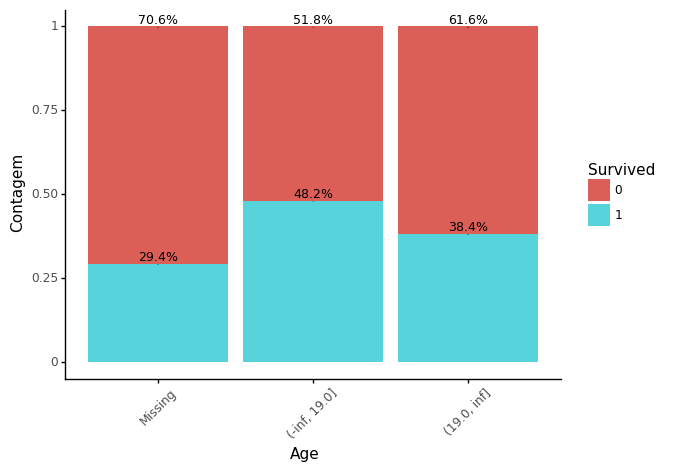

<ggplot: (125179881822)>

In [62]:
grafico_tab_frequencia_bivariada3(table_count_propSurvived_Age,'Survived','Age',size1=9,size2=0,angle=45)

## SibSp

In [63]:
calcula_tab_frequencia(tabela_de_entrada=df[df.Sample == 'train'],
                       nome_variavel='SibSp')

Tabela table_count_propSibSp criada!


,index,SibSp,SibSp_P,AccSibSp,AccSibSp_P
6,8,7,0.79,7,0.79
5,5,5,0.56,12,1.35
4,4,18,2.02,30,3.37
3,3,16,1.80,46,5.17
2,2,28,3.14,74,8.31
1,1,209,23.46,283,31.77
0,0,608,68.24,891,100.01


Gráfico gg_count_propSibSp criado!


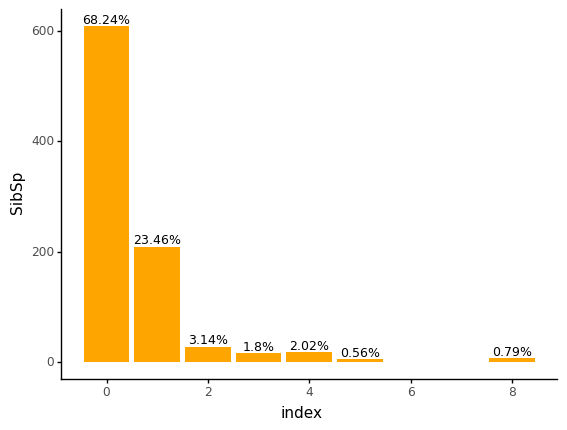

<ggplot: (125180394352)>

In [64]:
grafico_tab_frequencia2(table_count_prop=table_count_propSibSp,
                       nome_variavel='SibSp',
                       cor_grafico='orange',
                       size=9,
                       angle=0)

In [65]:
calcula_tab_frequencia_bivariada(df[df.Sample == 'train'],'Survived','SibSp')

Tabela table_count_propSurvived_SibSp criada!


,Survived,SibSp,Contagem,SumSibSp,AccSumSibSp,AccSumSibSp_P,Survived/SumSibSp,Survived/SumSibSp_P
0,0.0,0,398,608,608,68.24,0.6546,65.5
1,1.0,0,210,608,608,68.24,0.3454,34.5
2,0.0,1,97,209,817,23.46,0.4641,46.4
3,1.0,1,112,209,817,23.46,0.5359,53.6
4,0.0,2,15,28,845,3.14,0.5357,53.6
5,1.0,2,13,28,845,3.14,0.4643,46.4
6,0.0,3,12,16,861,1.80,0.7500,75.0
7,1.0,3,4,16,861,1.80,0.2500,25.0
8,0.0,4,15,18,879,2.02,0.8333,83.3
9,1.0,4,3,18,879,2.02,0.1667,16.7


Para adicionar as porcentagens, use size2 > 0!
Gráfico gg_count_propSurvived_SibSp2 criado!


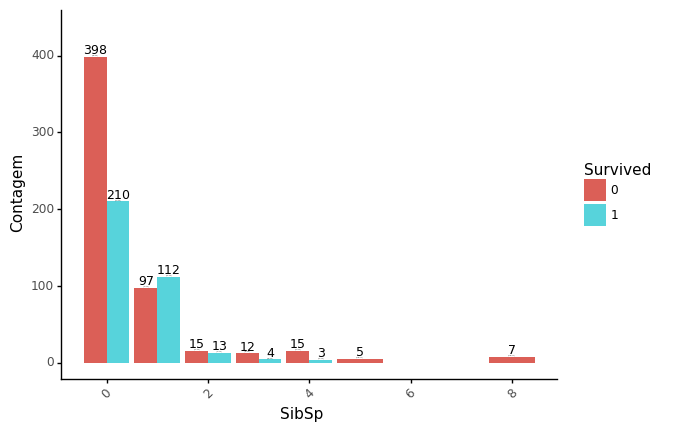

<ggplot: (125179882897)>

In [66]:
grafico_tab_frequencia_bivariada2(table_count_propSurvived_SibSp,'Survived','SibSp',size1=9,size2=0,angle=45)

Para adicionar as contagens, use size2 > 0!
Gráfico gg_count_propSurvived_SibSp3 criado!


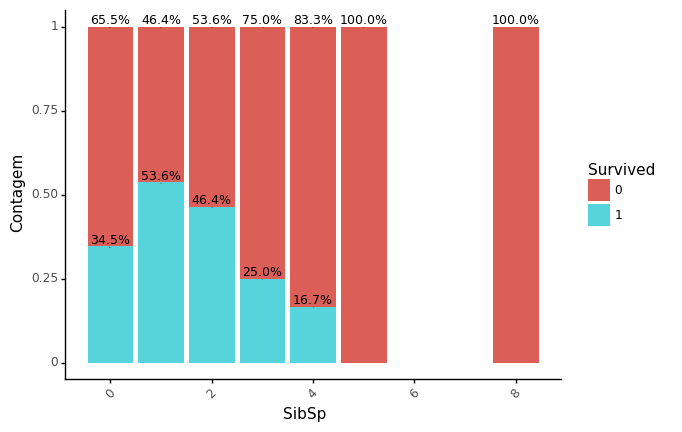

<ggplot: (125181669331)>

In [67]:
grafico_tab_frequencia_bivariada3(table_count_propSurvived_SibSp,'Survived','SibSp',size1=9,size2=0,angle=45)

## Parch

In [68]:
calcula_tab_frequencia(tabela_de_entrada=df[df.Sample == 'train'],
                       nome_variavel='Parch')

Tabela table_count_propParch criada!


,index,Parch,Parch_P,AccParch,AccParch_P
6,6,1,0.11,1,0.11
5,5,5,0.56,6,0.67
4,4,4,0.45,10,1.12
3,3,5,0.56,15,1.68
2,2,80,8.98,95,10.66
1,1,118,13.24,213,23.90
0,0,678,76.09,891,99.99


Gráfico gg_count_propParch criado!


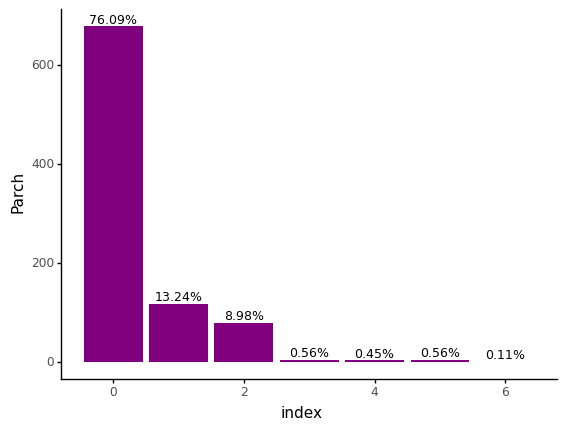

<ggplot: (125179879108)>

In [69]:
grafico_tab_frequencia2(table_count_prop=table_count_propParch,
                       nome_variavel='Parch',
                       cor_grafico='purple',
                       size=9,
                       angle=0)

In [70]:
calcula_tab_frequencia_bivariada(df[df.Sample == 'train'],'Survived','Parch')

Tabela table_count_propSurvived_Parch criada!


,Survived,Parch,Contagem,SumParch,AccSumParch,AccSumParch_P,Survived/SumParch,Survived/SumParch_P
0,0.0,0,445,678,678,76.09,0.6563,65.6
1,1.0,0,233,678,678,76.09,0.3437,34.4
2,0.0,1,53,118,796,13.24,0.4492,44.9
3,1.0,1,65,118,796,13.24,0.5508,55.1
4,0.0,2,40,80,876,8.98,0.5000,50.0
5,1.0,2,40,80,876,8.98,0.5000,50.0
6,0.0,3,2,5,881,0.56,0.4000,40.0
7,1.0,3,3,5,881,0.56,0.6000,60.0
8,0.0,4,4,4,885,0.45,1.0000,100.0
9,0.0,5,4,5,890,0.56,0.8000,80.0


Para adicionar as porcentagens, use size2 > 0!
Gráfico gg_count_propSurvived_Parch2 criado!


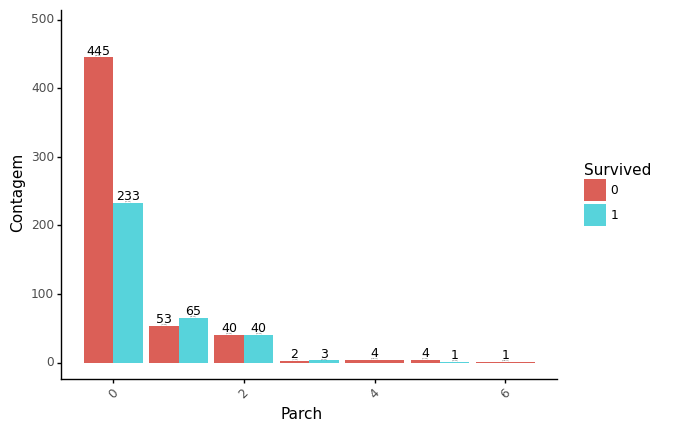

<ggplot: (125181965364)>

In [71]:
grafico_tab_frequencia_bivariada2(table_count_propSurvived_Parch,'Survived','Parch',size1=9,size2=0,angle=45)

Para adicionar as contagens, use size2 > 0!
Gráfico gg_count_propSurvived_Parch3 criado!


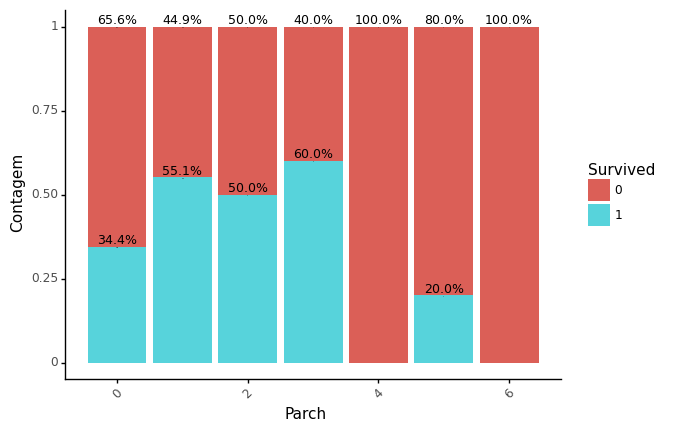

<ggplot: (125183143138)>

In [72]:
grafico_tab_frequencia_bivariada3(table_count_propSurvived_Parch,'Survived','Parch',size1=9,size2=0,angle=45)

## Fare

In [73]:
df[df.Sample == 'train']['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [74]:
binning_quantities(dados_entrada=df[df.Sample == 'train'],
                   nome_variavel='Fare',
                   nome_variavel_resposta='Survived',
                   method='Sturges')

Método Sturges : n (desconsidera nulos) =  891 |> k (desconsidera nulos) =  11
0       (-inf, 46.58]
1      (46.58, 93.15]
2       (-inf, 46.58]
3      (46.58, 93.15]
4       (-inf, 46.58]
            ...      
886     (-inf, 46.58]
887     (-inf, 46.58]
888     (-inf, 46.58]
889     (-inf, 46.58]
890     (-inf, 46.58]
Name: Fare, Length: 891, dtype: category
Categories (12, object): ['Missing' < (-inf, 46.58] < (46.58, 93.15] < (93.15, 139.73] ... (326.03, 372.6] < (372.6, 419.18] < (419.18, 465.75] < (465.75, inf]]
--------------------------------------------------------------------------------------------------
Survived    category
Fare        category
dtype: object
-------------------------------------------------
Tabela dados_saidaFare e lista limites_intervalosFare criadas!


(    Survived            Fare
 0        0.0   (-inf, 46.58]
 1        1.0  (46.58, 93.15]
 2        1.0   (-inf, 46.58]
 3        1.0  (46.58, 93.15]
 4        0.0   (-inf, 46.58]
 ..       ...             ...
 886      0.0   (-inf, 46.58]
 887      1.0   (-inf, 46.58]
 888      0.0   (-inf, 46.58]
 889      1.0   (-inf, 46.58]
 890      0.0   (-inf, 46.58]
 
 [891 rows x 2 columns],
 [-inf,
  46.58,
  93.15,
  139.73,
  186.3,
  232.88,
  279.45,
  326.03,
  372.6,
  419.18,
  465.75,
  inf])

In [75]:
calcula_tab_frequencia(tabela_de_entrada=dados_saidaFare,
                       nome_variavel='Fare')

Tabela table_count_propFare criada!


,index,Fare,Fare_P,AccFare,AccFare_P
11,"(465.75, inf]",3,0.34,3,0.34
10,"(419.18, 465.75]",0,0.00,3,0.34
9,"(372.6, 419.18]",0,0.00,3,0.34
8,"(326.03, 372.6]",0,0.00,3,0.34
7,"(279.45, 326.03]",0,0.00,3,0.34
6,"(232.88, 279.45]",8,0.90,11,1.24
5,"(186.3, 232.88]",9,1.01,20,2.25
4,"(139.73, 186.3]",11,1.23,31,3.48
3,"(93.15, 139.73]",24,2.69,55,6.17
2,"(46.58, 93.15]",116,13.02,171,19.19


Gráfico gg_count_propFare criado!


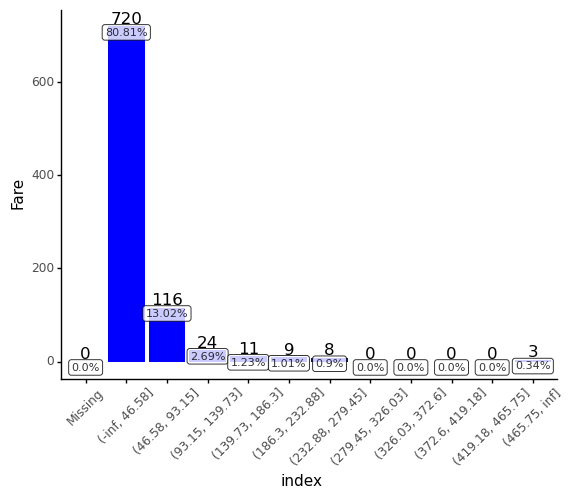

<ggplot: (125183186231)>

In [76]:
grafico_tab_frequencia3(table_count_prop=table_count_propFare,
                       nome_variavel='Fare',
                       cor_grafico='blue',
                       size1=12,
                       size2=8,
                       angle=45)

In [77]:
df[df.Sample == 'train'].groupby(['Survived'])['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0.0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1.0,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


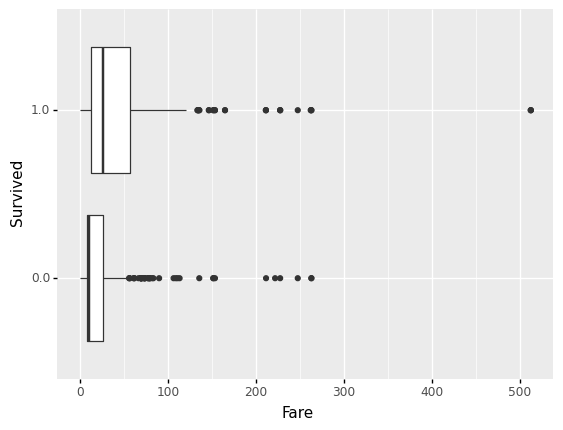

<ggplot: (125184271177)>

In [78]:
ggplot(aes(x='Survived',y='Fare'),data=df[df.Sample == 'train']) + geom_boxplot() + coord_flip()

# Preenchendo o dado faltante (Mr. Thomas Storey)

In [79]:
df_for_woe[df_for_woe['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample,Survived_BadGod
152,1044,NaN,3,"Storey, Mr. Thomas",male,"(19.0, inf]",0,0,3701,NaN,NaN,S,test,NaN


Uma das técnicas mais rápidas e menos trabalhosas para substituir um dado faltante é a utilização das próprias medidas de posição, apesar de existirem outras técnicas com melhor fundamentação teórica. Considerando que para o caso da variável Fare existe somente um dado faltante, essa técnica foi a escolhida. Além disso, visto que os dados de Fare e Pclass estão negativamente correlacionados, verificou-se o comportamento dessas duas variáveis para que um valor mais lógico pudesse ser utilizado para substituir o dado faltante.

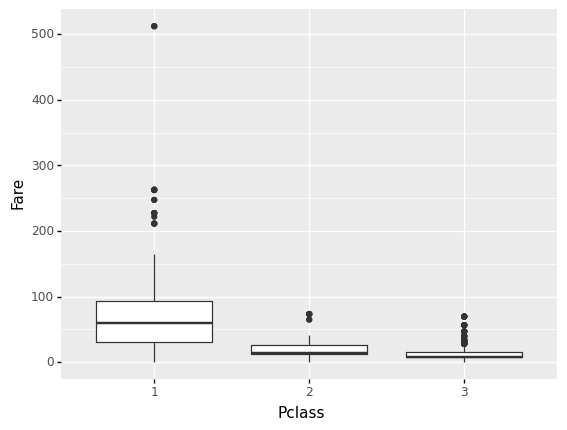

<ggplot: (125181604217)>

In [80]:
ggplot(aes(y='Fare',x='Pclass'),data=df_for_woe[df_for_woe.Sample == 'train']) + geom_boxplot()

A medida de posição escolhida foi a mediana. Além disso, como o indivíduo pertence a terceira classe, foi escolhida a mediana da terceira classe para substituir o dado faltante.

In [81]:
df_for_woe[df_for_woe.Sample == 'train'].groupby(['Pclass'])['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [82]:
df_for_woe['Fare'] = df_for_woe['Fare'].fillna(8.0500)

In [83]:
df_for_woe[df_for_woe['PassengerId'] == 1044]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample,Survived_BadGod
152,1044,NaN,3,"Storey, Mr. Thomas",male,"(19.0, inf]",0,0,3701,8.05,NaN,S,test,NaN


## Cabin

#### Formata a covariável Cabin

In [84]:
df_for_woe['Cabin'] = df_for_woe['Cabin'].cat.add_categories(['Missing']).fillna('Missing')

In [85]:
df_for_woe[df_for_woe.Sample == 'train']['Cabin'].cat.categories.values

array(['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23',
       'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7',
       'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22',
       'B24', 'B26', 'B28', 'B3', 'B30', 'B35', 'B36', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B45', 'B49', 'B5', 'B50',
       'B51 B53 B55', 'B52 B54 B56', 'B57 B59 B63 B66', 'B58 B60', 'B61',
       'B69', 'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B82 B84', 'B86',
       'B94', 'B96 B98', 'C101', 'C103', 'C104', 'C105', 'C106', 'C110',
       'C111', 'C116', 'C118', 'C123', 'C124', 'C125', 'C126', 'C128',
       'C130', 'C132', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C28',
       'C30', 'C31', 'C32', 'C39', 'C45', 'C46', 'C47', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55 C57', 'C6', 'C62 C64', 'C65',
       'C68', 'C7', 'C70', 'C78', 'C80', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C89', 'C90', 'C91', 'C92', 'C93', 'C95', 'C97', 'C99', 'D',
       'D

### **Binning 'Manual' - Com fusão de classes**

Agrupando as cabines

Possivelmente existem grupos de cabines com pessoas que têm maiores ou menores chances de sobrevivência. Por conta disso, esse agrupamento foi feito para verificar mais facilmente essa hipótese.

In [86]:
df_for_woe['Cabin'] = df_for_woe['Cabin'].str[0].replace({'M':'Missing'})
df_for_woe['Cabin'] = df_for_woe['Cabin'].astype('category')
df_for_woe['Cabin'] = df_for_woe['Cabin'].cat.reorder_categories(['A','B','C','D','E','F','G','T','Missing'])
df_for_woe['Cabin'].cat.categories.values

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Missing'], dtype=object)

In [87]:
calcula_tab_frequencia(tabela_de_entrada=df_for_woe[df_for_woe.Sample == 'train'],
                       nome_variavel='Cabin')

Tabela table_count_propCabin criada!


,index,Cabin,Cabin_P,AccCabin,AccCabin_P
8,Missing,687,77.10,687,77.10
7,T,1,0.11,688,77.21
6,G,4,0.45,692,77.66
5,F,13,1.46,705,79.12
4,E,32,3.59,737,82.71
3,D,33,3.70,770,86.41
2,C,59,6.62,829,93.03
1,B,47,5.27,876,98.30
0,A,15,1.68,891,99.98


Gráfico gg_count_propCabin criado!


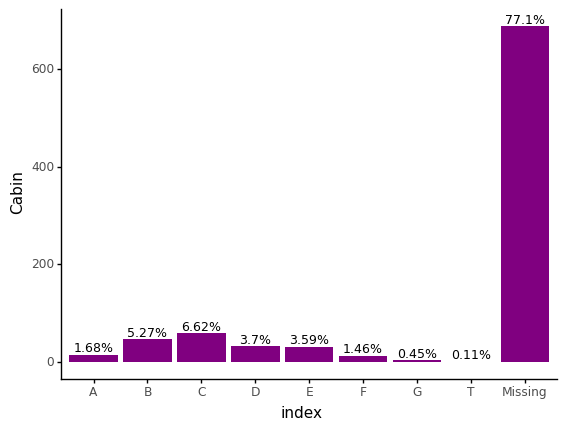

<ggplot: (125182718410)>

In [88]:
grafico_tab_frequencia2(table_count_prop=table_count_propCabin,
                       nome_variavel='Cabin',
                       cor_grafico='purple',
                       size=9,
                       angle=0)

In [89]:
df_for_woe[df_for_woe.Sample == 'train']['Cabin'].cat.categories.values

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Missing'], dtype=object)

In [90]:
breaks_list = {
    'Cabin': df_for_woe[df_for_woe.Sample == 'train']['Cabin'].cat.categories.values#(pd.DataFrame(df[df.Sample == 'train']['Cabin'].astype('object')).fillna('Missing'))['Cabin'].unique(),
}
# woe binning ------
bins = sc.woebin(df_for_woe[df_for_woe.Sample == 'train'],
                breaks_list=breaks_list,
                #special_values=,
                x='Cabin',
                y='Survived_BadGod')
bins['Cabin']['woe_period1'] = bins['Cabin']['woe'].shift(periods=1)
bins['Cabin']['woe_diff'] = bins['Cabin']['woe_period1'] - bins['Cabin']['woe']
bins['Cabin']['P_j/good'] = bins['Cabin']['good']/bins['Cabin']['good'].sum()
bins['Cabin']['P_j/bad'] = bins['Cabin']['bad']/bins['Cabin']['bad'].sum()
bins['Cabin']['RR'] = bins['Cabin']['P_j/good']/bins['Cabin']['P_j/bad']
bins['Cabin']['f*'] = np.log(bins['Cabin']['RR'])
bins['Cabin']['V(f*)'] = ((1-bins['Cabin']['P_j/good'])/(bins['Cabin']['good'].sum()*bins['Cabin']['P_j/good'])) + ((1-bins['Cabin']['P_j/bad'])/(bins['Cabin']['bad'].sum()*bins['Cabin']['P_j/bad']))
bins['Cabin']['RR_IC_low'] = np.exp(bins['Cabin']['f*'] - stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Cabin']['V(f*)']))
bins['Cabin']['RR_IC_Hight'] = np.exp(bins['Cabin']['f*'] + stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Cabin']['V(f*)']))
bins['Cabin']

[INFO] creating woe binning ...


C:\Users\joaom\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:113: UserWarning: The positive value in "Survived_BadGod" was replaced by 1 and negative value by 0.
C:\Users\joaom\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,...,is_special_values,woe_period1,woe_diff,P_j/good,P_j/bad,RR,f*,V(f*),RR_IC_low,RR_IC_Hight
0,Cabin,A,15,0.016835,7,8,0.533333,-0.337128,0.001970,0.474574,...,False,NaN,NaN,0.020468,0.014572,1.404605,0.339756,0.263112,0.513967,3.838602
1,Cabin,B,47,0.052750,35,12,0.255319,-1.541101,0.123616,0.474574,...,False,-0.337128,1.203973,0.102339,0.021858,4.682018,1.543729,0.107159,2.464850,8.893557
2,Cabin,C,59,0.066218,35,24,0.406780,-0.847954,0.049482,0.474574,...,False,-1.541101,-0.693147,0.102339,0.043716,2.341009,0.850582,0.065493,1.417645,3.865792
3,Cabin,D,33,0.037037,25,8,0.242424,-1.610094,0.093926,0.474574,...,False,-0.847954,0.762140,0.073099,0.014572,5.016447,1.612722,0.160255,2.288995,10.993794
4,Cabin,E,32,0.035915,24,8,0.250000,-1.569272,0.086968,0.474574,...,False,-1.610094,-0.040822,0.070175,0.014572,4.815789,1.571900,0.161921,2.188511,10.597079
5,Cabin,F,13,0.014590,8,5,0.384615,-0.940663,0.013379,0.474574,...,False,-1.569272,-0.628609,0.023392,0.009107,2.568421,0.943291,0.320255,0.847154,7.786997
6,Cabin,G,4,0.004489,2,2,0.500000,-0.470660,0.001031,0.474574,...,False,-0.940663,-0.470004,0.005848,0.003643,1.605263,0.473288,0.995255,0.227178,11.342942
7,Cabin,T,1,0.001122,0,1,1.000000,-0.365299,0.000293,0.474574,...,False,-0.470660,-0.105361,0.000000,0.001821,0.000000,-inf,inf,0.000000,NaN
8,Cabin,Missing,687,0.771044,206,481,0.700146,0.377332,0.103910,0.474574,...,False,-0.365299,-0.742631,0.602339,0.876138,0.687493,-0.374703,0.002188,0.627268,0.753500


{'Cabin': <Figure size 432x288 with 2 Axes>}

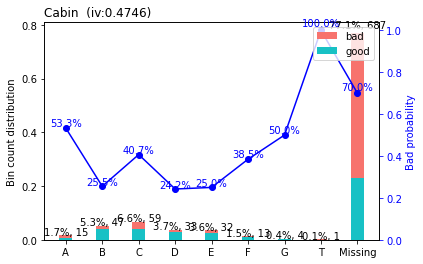

In [91]:
sc.woebin_plot(bins)

### **Método Optimal Binning - A partir das classes agregadas**

Essa junção foi feita a partir do **Binning 'Manual' - Com fusão de classes**. Isso foi feito para verificar se faria sentido diminuir o detalhamento das cabines para facilitar a interpretabilidade.

In [92]:
# woe binning ------
bins = sc.woebin(df_for_woe[df_for_woe.Sample == 'train'],
                x='Cabin',
                y='Survived_BadGod',
                method='tree',# "tree" and "chimerge" for optimal binning (numerical e categorical), # width' and 'freq' for equal binning that support numerical variables only.
                stop_limit=0.05)

bins['Cabin']['woe_period1'] = bins['Cabin']['woe'].shift(periods=1)
bins['Cabin']['woe_diff'] = bins['Cabin']['woe_period1'] - bins['Cabin']['woe']
bins['Cabin']['P_j/good'] = bins['Cabin']['good']/bins['Cabin']['good'].sum()
bins['Cabin']['P_j/bad'] = bins['Cabin']['bad']/bins['Cabin']['bad'].sum()
bins['Cabin']['RR'] = bins['Cabin']['P_j/good']/bins['Cabin']['P_j/bad']
bins['Cabin']['f*'] = np.log(bins['Cabin']['RR'])
bins['Cabin']['V(f*)'] = ((1-bins['Cabin']['P_j/good'])/(bins['Cabin']['good'].sum()*bins['Cabin']['P_j/good'])) + ((1-bins['Cabin']['P_j/bad'])/(bins['Cabin']['bad'].sum()*bins['Cabin']['P_j/bad']))
bins['Cabin']['RR_IC_low'] = np.exp(bins['Cabin']['f*'] - stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Cabin']['V(f*)']))
bins['Cabin']['RR_IC_Hight'] = np.exp(bins['Cabin']['f*'] + stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Cabin']['V(f*)']))
bins['Cabin']

[INFO] creating woe binning ...


C:\Users\joaom\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:113: UserWarning: The positive value in "Survived_BadGod" was replaced by 1 and negative value by 0.


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,...,is_special_values,woe_period1,woe_diff,P_j/good,P_j/bad,RR,f*,V(f*),RR_IC_low,RR_IC_Hight
0,Cabin,"A%,%B%,%C",121,0.135802,77,44,0.363636,-1.032903,0.149772,0.440283,...,False,NaN,NaN,0.225146,0.080146,2.809211,1.032903,0.030969,1.989712,3.966234
1,Cabin,"D%,%E%,%F",78,0.087542,57,21,0.269231,-1.471817,0.189004,0.440283,...,False,-1.032903,0.438913,0.166667,0.038251,4.357143,1.471817,0.060417,2.691391,7.053859
2,Cabin,"G%,%T%,%Missing",692,0.776655,208,484,0.699422,0.371259,0.101508,0.440283,...,False,-1.471817,-1.843076,0.608187,0.881603,0.689865,-0.371259,0.002128,0.630224,0.755150


{'Cabin': <Figure size 432x288 with 2 Axes>}

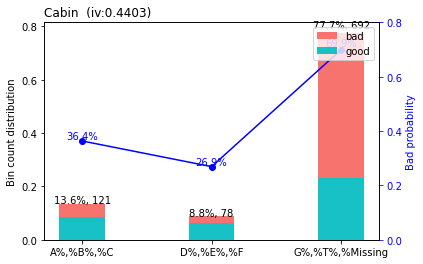

In [93]:
sc.woebin_plot(bins)

### **Binning 'Manual' - Ajuste do** *Método Optimal Binning -  A partir das classes agregadas*

Essa última junção foi feita a partir do **Método Optimal Binning - A partir das classes agregadas**. A única alteração que foi feita foi manter a classe missing isolada.

In [94]:
breaks_list = {
    'Cabin': ["A%,%B%,%C","D%,%E%,%F%,%G%,%T"]#(pd.DataFrame(df[df.Sample == 'train']['Cabin'].astype('object')).fillna('Missing'))['Cabin'].unique(),
}
# woe binning ------
bins = sc.woebin(df_for_woe[df_for_woe.Sample == 'train'],
                breaks_list=breaks_list,
                #special_values=,
                x='Cabin',
                y='Survived_BadGod')
bins['Cabin']['woe_period1'] = bins['Cabin']['woe'].shift(periods=1)
bins['Cabin']['woe_diff'] = bins['Cabin']['woe_period1'] - bins['Cabin']['woe']
bins['Cabin']['P_j/good'] = bins['Cabin']['good']/bins['Cabin']['good'].sum()
bins['Cabin']['P_j/bad'] = bins['Cabin']['bad']/bins['Cabin']['bad'].sum()
bins['Cabin']['RR'] = bins['Cabin']['P_j/good']/bins['Cabin']['P_j/bad']
bins['Cabin']['f*'] = np.log(bins['Cabin']['RR'])
bins['Cabin']['V(f*)'] = ((1-bins['Cabin']['P_j/good'])/(bins['Cabin']['good'].sum()*bins['Cabin']['P_j/good'])) + ((1-bins['Cabin']['P_j/bad'])/(bins['Cabin']['bad'].sum()*bins['Cabin']['P_j/bad']))
bins['Cabin']['RR_IC_low'] = np.exp(bins['Cabin']['f*'] - stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Cabin']['V(f*)']))
bins['Cabin']['RR_IC_Hight'] = np.exp(bins['Cabin']['f*'] + stats.norm.ppf(.975, loc=0, scale=1)*np.sqrt(bins['Cabin']['V(f*)']))
bins['Cabin']

[INFO] creating woe binning ...


C:\Users\joaom\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:113: UserWarning: The positive value in "Survived_BadGod" was replaced by 1 and negative value by 0.


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,...,is_special_values,woe_period1,woe_diff,P_j/good,P_j/bad,RR,f*,V(f*),RR_IC_low,RR_IC_Hight
0,Cabin,"A%,%B%,%C",121,0.135802,77,44,0.363636,-1.032903,0.149772,0.429176,...,False,NaN,NaN,0.225146,0.080146,2.809211,1.032903,0.030969,1.989712,3.966234
1,Cabin,"D%,%E%,%F%,%G%,%T",83,0.093154,59,24,0.289157,-1.372771,0.176811,0.429176,...,False,-1.032903,0.339868,0.172515,0.043716,3.946272,1.372771,0.053870,2.503936,6.219433
2,Cabin,missing,687,0.771044,206,481,0.700146,0.374703,0.102594,0.429176,...,False,-1.372771,-1.747475,0.602339,0.876138,0.687493,-0.374703,0.002188,0.627268,0.753500


{'Cabin': <Figure size 432x288 with 2 Axes>}

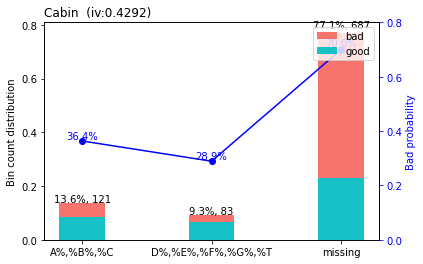

In [95]:
sc.woebin_plot(bins)

**Dicas para discretização via WOE:**
1) Todas as categorias calculadas têm pelo menos 5% das observações.
2) Todas as categorias calculadas têm valores diferentes de zero para o número de casos bons e ruins.
3) Os Woe's são distintos para cada categoria calculada. As categorias calculadas que tinham Woe's semelhantes foram agrupadas.
4) Valores ausentes estão em categorias separadas.
5) Os Woe's são monotônicos, isto é, estão crescendo ou diminuindo com os agrupamentos. (Recomendação do uso dessa dica é mais fraca do que para as outras dicas).

In [96]:
bins['Cabin'].bin

0            A%,%B%,%C
1    D%,%E%,%F%,%G%,%T
2              missing
Name: bin, dtype: object

### Aplicando as modificações nos dados

In [97]:
df_for_woe["Cabin"] = df_for_woe["Cabin"].replace({"A": "A%,%B%,%C", "B": "A%,%B%,%C", "C": "A%,%B%,%C",
                        "D":"D%,%E%,%F%,%G%,%T","E":"D%,%E%,%F%,%G%,%T","F":"D%,%E%,%F%,%G%,%T","G":"D%,%E%,%F%,%G%,%T","T":"D%,%E%,%F%,%G%,%T"})

In [98]:
df_for_woe

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample,Survived_BadGod
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(19.0, inf]",1,0,A/5 21171,7.2500,Missing,S,train,bad
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(19.0, inf]",1,0,PC 17599,71.2833,"A%,%B%,%C",C,train,good
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(19.0, inf]",0,0,STON/O2. 3101282,7.9250,Missing,S,train,good
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(19.0, inf]",1,0,113803,53.1000,"A%,%B%,%C",S,train,good
4,5,0.0,3,"Allen, Mr. William Henry",male,"(19.0, inf]",0,0,373450,8.0500,Missing,S,train,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,2,"Spector, Mr. Woolf",male,Missing,0,0,A.5. 3236,8.0500,Missing,S,test,NaN
414,1306,NaN,3,"Oliva y Ocana, Dona. Fermina",female,"(19.0, inf]",0,0,PC 17758,108.9000,"A%,%B%,%C",C,test,NaN
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,"(19.0, inf]",0,0,SOTON/O.Q. 3101262,7.2500,Missing,S,test,NaN
416,1308,NaN,2,"Ware, Mr. Frederick",male,Missing,0,0,359309,8.0500,Missing,S,test,NaN


In [99]:
# Função estava com problemas no momento em que foi utilizado (não substitui os valores corretamente).
#df_for_woe_binnarized = sc.woebin_ply(df_for_woe, bins)
#df_for_woe_binnarized

## Embarked

In [100]:
df_for_woe['Embarked'] = df_for_woe['Embarked'].cat.add_categories(['Missing'])
df_for_woe[['Embarked']] = df_for_woe[['Embarked']].fillna('Missing')

In [101]:
calcula_tab_frequencia(tabela_de_entrada=df_for_woe[df_for_woe.Sample == 'train'],
                       nome_variavel='Embarked')

Tabela table_count_propEmbarked criada!


,index,Embarked,Embarked_P,AccEmbarked,AccEmbarked_P
3,Missing,2,0.22,2,0.22
2,S,644,72.28,646,72.50
1,Q,77,8.64,723,81.14
0,C,168,18.86,891,100.00


In [102]:
df_for_woe[df_for_woe.Embarked == 'Missing']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample,Survived_BadGod
61,62,1.0,1,"Icard, Miss. Amelie",female,"(19.0, inf]",0,0,113572,80.0,"A%,%B%,%C",Missing,train,good
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,"(19.0, inf]",0,0,113572,80.0,"A%,%B%,%C",Missing,train,good


Intuitivamente, poderia ser utilizado o método de imputação de dados ausentes pela classe mais frequente pois são poucos casos (2 observações). Além disso, em pesquisas pela internet, foi constatado que as duas mulheres embarcaram em Southampton (S). Portanto, faz sentido seguir com esse preenchimento dos dados.

In [103]:
df_for_woe.loc[df_for_woe.PassengerId.isin([62,830]),'Embarked'] = df_for_woe.loc[df_for_woe.PassengerId.isin([62,830]),'Embarked'].replace({'Missing':'S'})

In [104]:
df_for_woe[df_for_woe.PassengerId.isin([62,830])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample,Survived_BadGod
61,62,1.0,1,"Icard, Miss. Amelie",female,"(19.0, inf]",0,0,113572,80.0,"A%,%B%,%C",S,train,good
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,"(19.0, inf]",0,0,113572,80.0,"A%,%B%,%C",S,train,good


In [105]:
calcula_tab_frequencia(tabela_de_entrada=df_for_woe[df_for_woe.Sample == 'train'],
                       nome_variavel='Embarked')

Tabela table_count_propEmbarked criada!


,index,Embarked,Embarked_P,AccEmbarked,AccEmbarked_P
3,Missing,0,0.00,0,0.00
2,S,646,72.50,646,72.50
1,Q,77,8.64,723,81.14
0,C,168,18.86,891,100.00


Gráfico gg_count_propEmbarked criado!


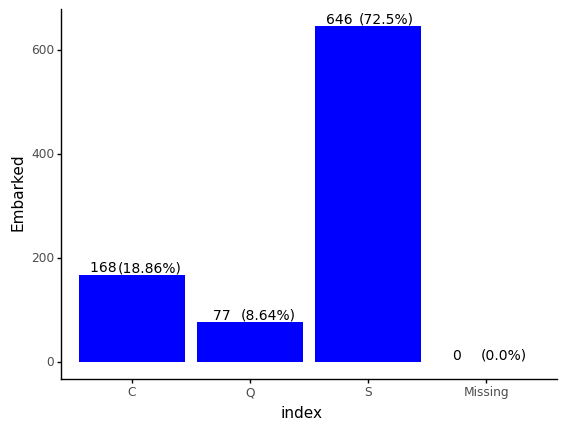

<ggplot: (125182694952)>

In [106]:
grafico_tab_frequencia(table_count_prop=table_count_propEmbarked,
                       nome_variavel='Embarked',
                       cor_grafico='blue',
                       nudge_x_e=-0.225,
                       nudge_x_d=0.15,
                       size=10)

In [107]:
calcula_tab_frequencia_bivariada(df_for_woe[df_for_woe.Sample == 'train'],'Survived','Embarked')

Tabela table_count_propSurvived_Embarked criada!


,Survived,Embarked,Contagem,SumEmbarked,AccSumEmbarked,AccSumEmbarked_P,Survived/SumEmbarked,Survived/SumEmbarked_P
0,0.0,C,75,168,168,18.86,0.4464,44.6
1,1.0,C,93,168,168,18.86,0.5536,55.4
2,0.0,Q,47,77,245,8.64,0.6104,61.0
3,1.0,Q,30,77,245,8.64,0.3896,39.0
4,0.0,S,427,646,891,72.50,0.6610,66.1
5,1.0,S,219,646,891,72.50,0.3390,33.9


Para retirar as porcentagens, use size2 = 0!
Gráfico gg_count_propSurvived_Embarked2 criado!


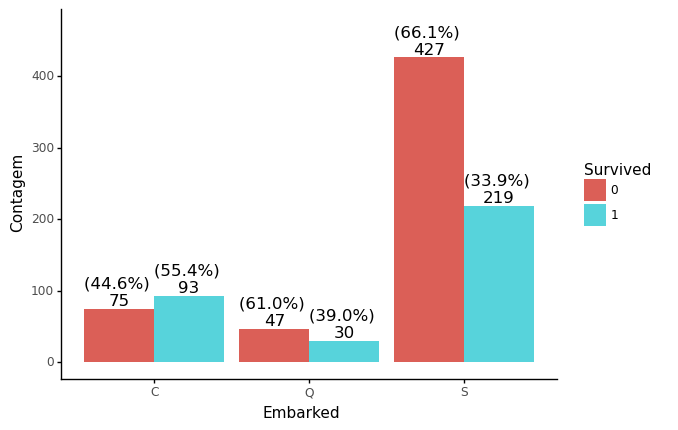

<ggplot: (125182694958)>

In [108]:
grafico_tab_frequencia_bivariada2(table_count_propSurvived_Embarked,'Survived','Embarked',angle=0,size1=12,size2=12)

Para adicionar as contagens, use size2 > 0!
Gráfico gg_count_propSurvived_Embarked3 criado!


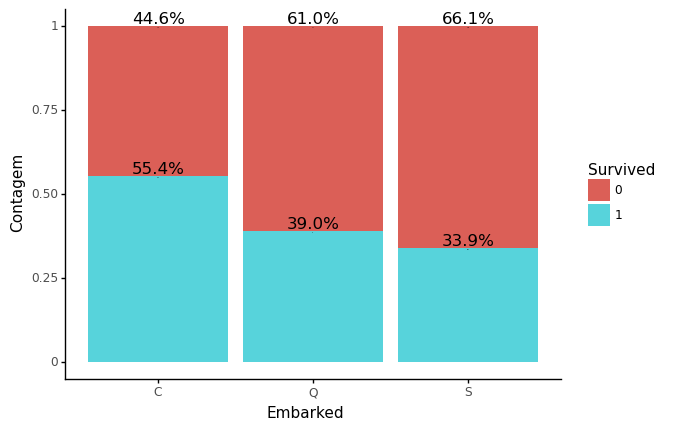

<ggplot: (125182057412)>

In [109]:
grafico_tab_frequencia_bivariada3(table_count_propSurvived_Embarked,'Survived','Embarked',size1=12,size2=0,angle=0)

# Cria tabelas finais (com dados tratados)

In [110]:
df_tidy = df_for_woe.copy().drop(columns=['Survived_BadGod'])
train_tidy = df_for_woe[df_for_woe.Sample == 'train'].drop(columns=['Survived_BadGod'])
test_tidy = df_for_woe[df_for_woe.Sample == 'test'].drop(columns=['Survived_BadGod'])

In [111]:
#df_tidy.to_pickle("df_tidy.pkl")
df_tidy = pd.read_pickle("df_tidy.pkl")
#train_tidy.to_pickle("train_tidy.pkl")
train_tidy = pd.read_pickle("train_tidy.pkl")
#test_tidy.to_pickle("test_tidy.pkl")
test_tidy = pd.read_pickle("test_tidy.pkl")

In [112]:
df_tidy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sample
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(19.0, inf]",1,0,A/5 21171,7.2500,Missing,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(19.0, inf]",1,0,PC 17599,71.2833,"A%,%B%,%C",C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(19.0, inf]",0,0,STON/O2. 3101282,7.9250,Missing,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(19.0, inf]",1,0,113803,53.1000,"A%,%B%,%C",S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,"(19.0, inf]",0,0,373450,8.0500,Missing,S,train


# Tabela de Metadados (Foco em Modelagem Estatística/Machine Learning)

In [113]:
tabela_metadados(tabela_de_entrada=train_tidy,
                 sufixo_da_tabela_saída='train_tidy',
                 lista_vars_drop=['PassengerId','Name','Ticket','Sample'])

___________________________________________________________________
O shape da tabela de entrada é: 
(891, 13)
Tabela metadata_table_train_tidy criada!


,columns,dtypes,nunique,nunique_with_null,null_value_count,p_null_value_count,p_max_duplicated_value,drop
0,PassengerId,int64,891,891,0,0.0,0.001122,True
1,Survived,category,2,2,0,0.0,0.616162,False
2,Pclass,category,3,3,0,0.0,0.551066,False
3,Name,object,891,891,0,0.0,0.001122,True
4,Sex,category,2,2,0,0.0,0.647587,False
5,Age,category,3,3,0,0.0,0.617284,False
6,SibSp,int64,7,7,0,0.0,0.682379,False
7,Parch,int64,7,7,0,0.0,0.760943,False
8,Ticket,object,681,681,0,0.0,0.007856,True
9,Fare,float64,248,248,0,0.0,0.048260,False


In [114]:
tabela_metadados(tabela_de_entrada=test_tidy,
                 sufixo_da_tabela_saída='test_tidy',
                 lista_vars_drop=['PassengerId','Name','Ticket','Sample','Survived'])

___________________________________________________________________
O shape da tabela de entrada é: 
(418, 13)
Tabela metadata_table_test_tidy criada!


<ipython-input-3-50043b968bee>:26: RuntimeWarning: invalid value encountered in longlong_scalars


,columns,dtypes,nunique,nunique_with_null,null_value_count,p_null_value_count,p_max_duplicated_value,drop
0,PassengerId,int64,418,418,0,0.0,0.002392,True
1,Survived,category,0,1,418,1.0,NaN,True
2,Pclass,category,3,3,0,0.0,0.564593,False
3,Name,object,418,418,0,0.0,0.002392,True
4,Sex,category,2,2,0,0.0,0.636364,False
5,Age,category,3,3,0,0.0,0.648325,False
6,SibSp,int64,7,7,0,0.0,0.677033,False
7,Parch,int64,8,8,0,0.0,0.775120,False
8,Ticket,object,363,363,0,0.0,0.011962,True
9,Fare,float64,169,169,0,0.0,0.050239,False


In [115]:
tabela_metadados(tabela_de_entrada=df_tidy,
                 sufixo_da_tabela_saída='df_tidy',
                 lista_vars_drop=['PassengerId','Name','Ticket'])

___________________________________________________________________
O shape da tabela de entrada é: 
(1309, 13)
Tabela metadata_table_df_tidy criada!


,columns,dtypes,nunique,nunique_with_null,null_value_count,p_null_value_count,p_max_duplicated_value,drop
0,PassengerId,int64,1309,1309,0,0.000000,0.000764,True
1,Survived,category,2,3,418,0.319328,0.616162,False
2,Pclass,category,3,3,0,0.000000,0.555386,False
3,Name,object,1307,1307,0,0.000000,0.001528,True
4,Sex,category,2,2,0,0.000000,0.644003,False
5,Age,category,3,3,0,0.000000,0.627196,False
6,SibSp,int64,7,7,0,0.000000,0.680672,False
7,Parch,int64,8,8,0,0.000000,0.765470,False
8,Ticket,object,929,929,0,0.000000,0.008403,True
9,Fare,float64,281,281,0,0.000000,0.046600,False


In [116]:
train_ml = train_tidy.copy()
test_ml = test_tidy.copy()

train_ml = train_ml[metadata_table_train_tidy[~metadata_table_train_tidy['drop']]['columns'].values]
test_ml = test_ml[metadata_table_test_tidy[~metadata_table_test_tidy['drop']]['columns'].values]

In [117]:
train_ml

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0.0,3,male,"(19.0, inf]",1,0,7.2500,Missing,S
1,1.0,1,female,"(19.0, inf]",1,0,71.2833,"A%,%B%,%C",C
2,1.0,3,female,"(19.0, inf]",0,0,7.9250,Missing,S
3,1.0,1,female,"(19.0, inf]",1,0,53.1000,"A%,%B%,%C",S
4,0.0,3,male,"(19.0, inf]",0,0,8.0500,Missing,S
...,...,...,...,...,...,...,...,...,...
886,0.0,2,male,"(19.0, inf]",0,0,13.0000,Missing,S
887,1.0,1,female,"(-inf, 19.0]",0,0,30.0000,"A%,%B%,%C",S
888,0.0,3,female,Missing,1,2,23.4500,Missing,S
889,1.0,1,male,"(19.0, inf]",0,0,30.0000,"A%,%B%,%C",C


In [118]:
test_ml

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,"(19.0, inf]",0,0,7.8292,Missing,Q
1,1,female,"(19.0, inf]",1,0,7.0000,Missing,S
2,3,male,"(19.0, inf]",0,0,9.6875,Missing,Q
3,1,male,"(19.0, inf]",0,0,8.6625,Missing,S
4,3,female,"(19.0, inf]",1,1,12.2875,Missing,S
...,...,...,...,...,...,...,...,...
413,2,male,Missing,0,0,8.0500,Missing,S
414,3,female,"(19.0, inf]",0,0,108.9000,"A%,%B%,%C",C
415,3,male,"(19.0, inf]",0,0,7.2500,Missing,S
416,2,male,Missing,0,0,8.0500,Missing,S


# Tratamento das variáveis para Modelagem Estatística/Machine Learning

## LabelEncoder (Utilizado para a variável resposta)

In [119]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_ml['Survived'] = label_encoder.fit_transform(train_ml['Survived'])

## OrdinalEncoder (Utilizado para variáveis qualitativas ordinais)

In [120]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
# transform data
train_ml[['Pclass','Age']] = encoder.fit_transform(train_ml[['Pclass','Age']].astype('str'))
test_ml[['Pclass','Age']] = encoder.fit_transform(test_ml[['Pclass','Age']].astype('str'))

## Dummy Variable Encoding - **OneHotEncoder without the first category** (Utilizado para variáveis qualitativas nominais)

In [121]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)

columns_dummy = ['Sex','Cabin','Embarked']

train_ml_encoded = encoder.fit_transform(train_ml[columns_dummy])
column_names = encoder.get_feature_names(columns_dummy)
train_ml_encoded = pd.DataFrame(train_ml_encoded, columns= column_names)

test_ml_encoded = encoder.fit_transform(test_ml[columns_dummy])
column_names = encoder.get_feature_names(columns_dummy)
test_ml_encoded = pd.DataFrame(test_ml_encoded, columns= column_names)

train_ml = train_ml.drop(columns=columns_dummy)
test_ml = test_ml.drop(columns=columns_dummy)

In [122]:
train_ml = pd.concat([train_ml,train_ml_encoded],axis=1)
train_ml

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,"Cabin_D%,%E%,%F%,%G%,%T",Cabin_Missing,Embarked_Q,Embarked_S
0,0,2.0,1.0,1,0,7.2500,1.0,0.0,1.0,0.0,1.0
1,1,0.0,1.0,1,0,71.2833,0.0,0.0,0.0,0.0,0.0
2,1,2.0,1.0,0,0,7.9250,0.0,0.0,1.0,0.0,1.0
3,1,0.0,1.0,1,0,53.1000,0.0,0.0,0.0,0.0,1.0
4,0,2.0,1.0,0,0,8.0500,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,1.0,1.0,0,0,13.0000,1.0,0.0,1.0,0.0,1.0
887,1,0.0,0.0,0,0,30.0000,0.0,0.0,0.0,0.0,1.0
888,0,2.0,2.0,1,2,23.4500,0.0,0.0,1.0,0.0,1.0
889,1,0.0,1.0,0,0,30.0000,1.0,0.0,0.0,0.0,0.0


In [123]:
test_ml = pd.concat([test_ml,test_ml_encoded],axis=1)
test_ml

,Pclass,Age,SibSp,Parch,Fare,Sex_male,"Cabin_D%,%E%,%F%,%G%,%T",Cabin_Missing,Embarked_Q,Embarked_S
0,2.0,1.0,0,0,7.8292,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1,0,7.0000,0.0,0.0,1.0,0.0,1.0
2,2.0,1.0,0,0,9.6875,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0,0,8.6625,1.0,0.0,1.0,0.0,1.0
4,2.0,1.0,1,1,12.2875,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,1.0,2.0,0,0,8.0500,1.0,0.0,1.0,0.0,1.0
414,2.0,1.0,0,0,108.9000,0.0,0.0,0.0,0.0,0.0
415,2.0,1.0,0,0,7.2500,1.0,0.0,1.0,0.0,1.0
416,1.0,2.0,0,0,8.0500,1.0,0.0,1.0,0.0,1.0


# Feature Selection

## RFECV - Logistic Regression

C:\Users\joaom\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


Optimal number of features : 8


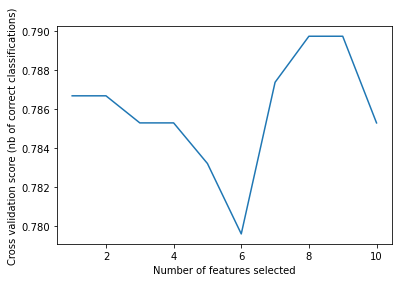

In [125]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
lr = LogisticRegression(max_iter=500)
# The "accuracy" scoring is proportional to the number of correct
# classifications

# Definindo os valores para os folds
num_folds = 100
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=lr, step=1, cv=kfold,
              scoring='accuracy',
              min_features_to_select=min_features_to_select)
rfecv.fit(train_ml.drop(columns='Survived'), train_ml['Survived'])

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [127]:
print(rfecv.support_)
print(rfecv.ranking_)
f = rfecv.get_support(1) #the most important features
names = train_ml.drop(columns='Survived').columns[f] # final features`
names

[ True  True  True  True False  True  True  True False  True]
[1 1 1 1 3 1 1 1 2 1]


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_male',
       'Cabin_D%,%E%,%F%,%G%,%T', 'Cabin_Missing', 'Embarked_S'],
      dtype='object')

In [128]:
rfecv.grid_scores_.max()

0.7897222222222219

Apesar do método de seleção de variável ter selecionado apenas algumas categorias da variável Embarked, (Para Embarked, sobrou somente Embarked_S e não Embarked_Q), todas as categorias foram adicionadas no modelo. A única variável que não foi selecionada é Fare.

In [129]:
names_best_variables = list()
for i in range(0,len(names)):   
    names_best_variables.insert(i, names.str.split('_')[i][0]) # Adicionar o nome das variaveis antes de '_'
names_best_variables = list(dict.fromkeys(names_best_variables)) # remover duplicatas
names_best_variables

['Pclass', 'Age', 'SibSp', 'Parch', 'Sex', 'Cabin', 'Embarked']

In [130]:
train_ml = train_ml.drop(columns='Fare')
train_ml

,Survived,Pclass,Age,SibSp,Parch,Sex_male,"Cabin_D%,%E%,%F%,%G%,%T",Cabin_Missing,Embarked_Q,Embarked_S
0,0,2.0,1.0,1,0,1.0,0.0,1.0,0.0,1.0
1,1,0.0,1.0,1,0,0.0,0.0,0.0,0.0,0.0
2,1,2.0,1.0,0,0,0.0,0.0,1.0,0.0,1.0
3,1,0.0,1.0,1,0,0.0,0.0,0.0,0.0,1.0
4,0,2.0,1.0,0,0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,0,1.0,1.0,0,0,1.0,0.0,1.0,0.0,1.0
887,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1.0
888,0,2.0,2.0,1,2,0.0,0.0,1.0,0.0,1.0
889,1,0.0,1.0,0,0,1.0,0.0,0.0,0.0,0.0


In [131]:
test_ml = test_ml.drop(columns='Fare')
test_ml

,Pclass,Age,SibSp,Parch,Sex_male,"Cabin_D%,%E%,%F%,%G%,%T",Cabin_Missing,Embarked_Q,Embarked_S
0,2.0,1.0,0,0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1,0,0.0,0.0,1.0,0.0,1.0
2,2.0,1.0,0,0,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0,0,1.0,0.0,1.0,0.0,1.0
4,2.0,1.0,1,1,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
413,1.0,2.0,0,0,1.0,0.0,1.0,0.0,1.0
414,2.0,1.0,0,0,0.0,0.0,0.0,0.0,0.0
415,2.0,1.0,0,0,1.0,0.0,1.0,0.0,1.0
416,1.0,2.0,0,0,1.0,0.0,1.0,0.0,1.0


# Avaliando a Performance

## Algoritmos de Classificação

### Métricas para Algoritmos de Classificação

https://scikit-learn.org/stable/modules/model_evaluation.html

# Seleção do Modelo Preditivo

LR: 0.789722 (0.164652)
LDA: 0.789861 (0.155054)
NB: 0.779167 (0.157129)
KNN: 0.787500 (0.131461)
SVM: 0.806944 (0.144277)
CART: 0.789722 (0.135173)
Bagging: 0.794028 (0.138054)
RandomForest: 0.795139 (0.132657)
AdaBoost: 0.785000 (0.130015)


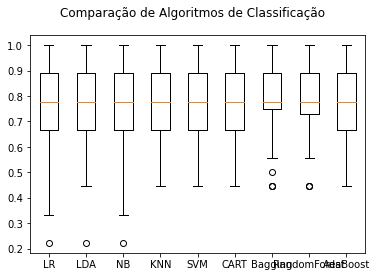

In [133]:
# Import dos módulos
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

max_iter=500
num_trees = 100

# Definindo os valores para o número de folds
num_folds = 100
seed = 7

# Preparando a lista de modelos
modelos = []
modelos.append(('LR', LogisticRegression(max_iter=max_iter)))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('SVM', SVC()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('Bagging',BaggingClassifier(base_estimator = DecisionTreeClassifier(),
                                                      n_estimators = num_trees, random_state = seed)))
modelos.append(('RandomForest',RandomForestClassifier(n_estimators = num_trees, max_features = 'auto', random_state = seed)))
modelos.append(('AdaBoost',AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),
                                                      n_estimators = num_trees, random_state = seed)))


# Avaliando cada modelo em um loop
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, shuffle=True, random_state = seed)
    cv_results = cross_val_score(modelo, train_ml.drop(columns='Survived'), train_ml['Survived'], cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

## Otimização do Modelo - Ajuste de Hyperparâmetros

### Grid Search Parameter Tuning

In [134]:
# Import dos módulos
from pandas import read_csv
from sklearn.model_selection import GridSearchCV

# Definindo os valores que serão testados
valores_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

# Criando o modelo
modelo = SVC()

# Criando o grid
grid = GridSearchCV(estimator = modelo, param_grid = valores_grid)
grid.fit(train_ml.drop(columns='Survived'), train_ml['Survived'])

# Print do resultado
print("Acurácia: %.3f" % (grid.best_score_ * 100))
print("Melhores Parâmetros do Modelo:\n", grid.best_estimator_)

Acurácia: 81.257
Melhores Parâmetros do Modelo:
 SVC(C=1, gamma=0.1)


### Métricas para Algoritmos de Classificação

In [135]:
# Salvando o resultado do seu trabalho
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Criando o dataset de treino e de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(train_ml.drop(columns='Survived'),
                                       train_ml['Survived'], test_size = teste_size, random_state = seed)

In [136]:
# Criando o modelo
modelo = grid.best_estimator_

# Treinando o modelo
modelo.fit(X_treino, Y_treino)

# Fazendo as previsões e construindo o relatório
previsoes = modelo.predict(X_treino)
report = classification_report(Y_treino, previsoes)

# Imprimindo o relatório
print(report)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       373
           1       0.82      0.71      0.76       223

    accuracy                           0.83       596
   macro avg       0.83      0.81      0.82       596
weighted avg       0.83      0.83      0.83       596



In [137]:
# Criando o modelo
modelo = grid.best_estimator_

# Treinando o modelo
modelo.fit(X_teste, Y_teste)

# Fazendo as previsões e construindo o relatório
previsoes = modelo.predict(X_teste)
report = classification_report(Y_teste, previsoes)

# Imprimindo o relatório
print(report)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       176
           1       0.80      0.66      0.72       119

    accuracy                           0.80       295
   macro avg       0.80      0.78      0.78       295
weighted avg       0.80      0.80      0.79       295



# Salvando o resultado do seu trabalho

In [138]:
import pickle

# Salvando o modelo
arquivo = 'modelo_classificador_final.sav'
pickle.dump(modelo, open(arquivo, 'wb'))
print("Modelo salvo!")

Modelo salvo!


In [139]:
# Carregando o arquivo
modelo_classificador_final = pickle.load(open(arquivo, 'rb'))
print("Modelo carregado!")


Modelo carregado!


In [140]:
modelo_classificador_final.predict(test_ml)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [144]:
test = pd.read_csv('../test.csv',sep = ",")
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [164]:
predict_submission = pd.concat([test['PassengerId'],
                pd.DataFrame({'Survived':modelo_classificador_final.predict(test_ml)})],axis=1)
predict_submission.to_csv('predict_submission.csv',index=False,sep=',')
predict_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
